# Notes

- Clean up train function (split up into train and validation)
- crop outer pixels for validation

- Different distributions for output (log-normal, Poisson)
- Regular features in variance map (->filter size in output layers?)

## Observations for TestNet
Fixed var log likelihood: gas only: ~22
Free var log likelihood: gas: ~28 (same for gas+pressure+stars), pressure only: ~220 (higher for combination), stars: ~ 1500

Artefacts in pressure variance after 15 epochs
KL doesn't seem to go to zero in pressure only case

## Set up stuff

In [1]:
import os

machine = "laptop"

if machine == "laptop":
    data_path = "../data/training_data/BAHAMAS/stacks_uncompressed/"
    
elif machine == "colab":
    import subprocess
    # Get cosmotools
    # Get baryon_painter
    # Get pytorch
    output = subprocess.check_output([sys.executable, '-m', 'pip', 'install', 'torch'])

    from baryon_painter.utils.google_drive import download_files_in_folder
    
    from google.colab import auth
    auth.authenticate_user()

    target_folder_id = "1Rdvmw_l7xzEo38gGVEro69bE-TJQuvh9"
    data_path = "/tmp/stacks/"
    
    os.makedirs(data_path, exist_ok=True)
    download_files_in_folder(target_folder_id, data_path)    
    
    
    

## Import stuff

In [3]:
import torch
import torch.utils.data

import numpy as np
import math
import collections
import os

%matplotlib inline
import matplotlib.pyplot as plt

from cosmotools.power_spectrum_tools import pseudo_Pofk
from cosmotools.plotting import subplot_colorbar, plot_power_spectrum

from baryon_painter.utils.datasets import BAHAMASDataset
from baryon_painter.utils.data_transforms import create_split_scale_transform

pi = np.pi

## Load data

In [143]:
# data_path = "/Users/yooken/Research/painting_baryons/data/training_data/BAHAMAS/"
data_path = "/tmp"

class SimulationData:
    def __init__(self, data_sets, train_validation_split=(0.8, 0.1), ):
        
        self.fields = []
        self.slices = collections.OrderedDict()
        
        self.transforms = collections.OrderedDict()
        self.inverse_transforms = collections.OrderedDict()
        self.transformed_slices = collections.OrderedDict()
                
        self.volume_mean = collections.OrderedDict()
        
        self.n_volume = 0
        
        self.n_feature = len(data_sets)-1
        self.dim = None
        self.data_shape = None
        
        self.n_sample = None
        
        for data_spec in data_sets:
            field = data_spec["field"]
            self.fields.append(field)
            
            self.slices[field] = None
            self.volume_mean[field] = []
            self.transforms[field] = []
            self.inverse_transforms[field] = []
            
            self.n_volume = len(data_spec["path"])
            for i, fn in enumerate(data_spec["path"]):
                data = np.load(fn, mmap_mode="r")
                
                if self.dim is None:
                    self.dim = data["slices"].shape[-2:]
                elif self.dim != data["slices"].shape[-2:]:
                    raise RuntimeError("Size mismatch of data set: {} vs {}".format(self.dim, 
                                                                                    data["slices"].shape[-2:]))
                if self.data_shape is None:
                    self.data_shape = data["slices"].shape[:4]
                if self.n_sample is None:
                    self.n_sample = self.n_volume * 3 * data["n_side"]**2 * data["n_depth"]
                    
                if self.slices[field] is None:
                    self.slices[field] = np.empty((self.n_volume, *data["slices"].shape))
                
                self.slices[field][i] = data["slices"]
                self.volume_mean[field].append(data["mean"])
                       
                self.transforms[field].append(self.build_transform(data_spec["transform"], field, i))
                self.inverse_transforms[field].append(self.build_transform(data_spec["inverse_transform"], field, i))
                
            self.transformed_slices[field] = np.zeros((self.n_volume, *self.data_shape), dtype=bool)
            
            if sum(train_validation_split) > 1:
                raise ValueError("Split must sum to <= 1.")
                
            self.n_sample_training = int(self.n_sample * train_validation_split[0])
            self.training_indices = np.array(np.unravel_index(np.arange(self.n_sample_training), 
                                                              (self.n_volume, *self.data_shape))).T
            self.training_data = SimulationDataSubset(self, self.training_indices)
            
            self.n_sample_validation = int(self.n_sample * train_validation_split[1])
            if self.n_sample_validation > 0:
                self.validation_indices = np.array(np.unravel_index(np.arange(self.n_sample_training, 
                                                                              self.n_sample_training+self.n_sample_validation), 
                                                                    (self.n_volume, *self.data_shape))).T
                self.validation_data = SimulationDataSubset(self, self.validation_indices)
                
            if sum(train_validation_split) < 1:
                self.n_sample_test = int(self.n_sample * (1-sum(train_validation_split)))
            else:
                self.n_sample_test = 0
            if self.n_sample_test > 0:
                self.test_indices = np.array(np.unravel_index(np.arange(self.n_sample_training+self.n_sample_validation,
                                                                        self.n_sample_training+self.n_sample_validation+self.n_sample_test), 
                                                              (self.n_volume, *self.data_shape))).T
                self.test_data = SimulationDataSubset(self, self.test_indices)


    def apply_transforms(self):
        for field in self.fields:
            for v in range(self.n_volume):
                not_transformed  = ~self.transformed_slices[field][v]
                self.slices[field][v][not_transformed] = self.transforms[field][v](self.slices[field][v][not_transformed])
                self.transformed_slices[field][v][not_transformed] = True
     
    def build_transform(self, transform, field, volume=0):
        def t(d, copy=True):
            if copy:
                x = np.copy(d)
            else:
                x = d
            for action in transform:
                if callable(action):
                    x = action(x)
                elif action == "divide_by_mean":
                    x /= self.volume_mean[field][volume]
                elif action == "multiply_by_mean":
                    x *= self.volume_mean[field][volume]
                else:
                    raise NotImplemented("Action {} not supported yet!".format(action))
            return x
        return t

class SimulationDataSubset(torch.utils.data.Dataset):
    def __init__(self, super_set, indices):
        self.data = super_set.slices
        self.already_transformed = super_set.transformed_slices
        self.transforms = super_set.transforms
        self.inverse_transforms = super_set.inverse_transforms
        
        self.indices = indices
        
    def get_transform(self, field, idx):
        idx = tuple(self.indices[idx])
        return self.transforms[field][idx[0]]
    
    def get_inverse_transform(self, field, idx):
        idx = tuple(self.indices[idx])
        return self.inverse_transforms[field][idx[0]]
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        idx = tuple(self.indices[idx])
        output = []
        for field, slices in self.data.items():
            if not self.already_transformed[field][idx]:
                slices[idx] = self.transforms[field][idx[0]](slices[idx], copy=False)
                self.already_transformed[field][idx] = True
            output.append(torch.tensor(slices[idx], dtype=torch.float).unsqueeze(0))
        return output
        
# k_transform = 6
# field_transform = lambda d: 2*d/(d+k_transform) - 1
# inv_field_transforms = [lambda d: (-k_transform*(d+1)/(d-1))*mean for mean in BAHAMAS_data.data_mean.values()]

k_transform = 6
field_transform = lambda d: np.piecewise(d, [d > 0,], [lambda x: np.tanh(np.log(x)/k_transform), lambda x: -1])
inv_field_transforms = lambda d: np.piecewise(d, [d > -1,], [lambda x: np.exp(np.arctanh(x)*k_transform), lambda x: 0])

data_sets = [{"field" :            "dm",
              "path" :              [os.path.join(data_path, "slices_AGN_TUNED_v1_dm_z0.0_1024_32x4x4.npz"),
                                     os.path.join(data_path, "slices_AGN_TUNED_v2_dm_z0.0_1024_32x4x4.npz")],
              "transform" :         ["divide_by_mean", field_transform],
              "inverse_transform" : [inv_field_transforms, "multiply_by_mean"]},
#              {"field" :            "gas",
#               "path" :              [os.path.join(data_path, "slices_AGN_TUNED_v1_gas_z0.0_1024_32x4x4.npz"),
#                                      os.path.join(data_path, "slices_AGN_TUNED_v2_gas_z0.0_1024_32x4x4.npz")],
#               "transform" :         ["divide_by_mean", field_transform],
#               "inverse_transform" : [inv_field_transforms, "multiply_by_mean"]},
             {"field" :            "pressure",
              "path" :              [os.path.join(data_path, "slices_AGN_TUNED_v1_pressure_z0.0_1024_32x4x4.npz"),
                                     os.path.join(data_path, "slices_AGN_TUNED_v2_pressure_z0.0_1024_32x4x4.npz")],
              "transform" :         ["divide_by_mean", field_transform],
              "inverse_transform" : [inv_field_transforms, "multiply_by_mean"]},
#              {"field" :            "stars",
#               "path" :              [os.path.join(data_path, "slices_AGN_TUNED_v1_stars_z0.0_1024_32x4x4.npz"),
#                                      os.path.join(data_path, "slices_AGN_TUNED_v2_stars_z0.0_1024_32x4x4.npz")],
#               "transform" :         ["divide_by_mean", field_transform],
#               "inverse_transform" : [inv_field_transforms, "multiply_by_mean"]},
            ]

BAHAMAS_data = SimulationData(data_sets)



In [30]:
BAHAMAS_data.volume_mean["gas"]

[array(0.15555121, dtype=float32), array(0.15547559, dtype=float32)]

In [27]:
BAHAMAS_data.validation_data.already_transformed["dm"].shape
BAHAMAS_data.validation_data.indices[0].shape

BAHAMAS_data.validation_data.already_transformed["dm"][tuple(BAHAMAS_data.validation_data.indices[1])]

False

In [0]:
%time BAHAMAS_data[0][1].shape
%time BAHAMAS_data[0][1].shape

BAHAMAS_data.apply_transforms()

CPU times: user 1 ms, sys: 0 ns, total: 1 ms
Wall time: 552 µs
CPU times: user 1e+03 µs, sys: 0 ns, total: 1e+03 µs
Wall time: 1.03 ms


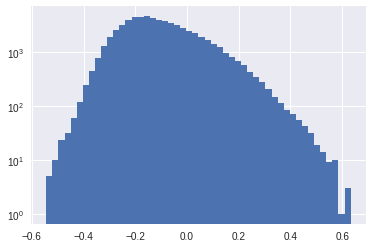

In [85]:
_ = plt.hist(BAHAMAS_data[0][1].numpy().flatten(), bins=50)
plt.yscale("log")

## Misc definitions

In [107]:
s = "{outer:>{width}s} : {value:.3e}".format(outer="ah", width=5, value=1.123)
print(s)


   ah : 1.123e+00


In [131]:
class TrainingStats:
    def __init__(self, loss_terms=[], moving_average_window=100):
        self.mavg_window = moving_average_window
        self.n_batches = 0
        self.n_processed_samples = []
        
        self.loss_terms = collections.OrderedDict()
        for loss_term in loss_terms:
            self.loss_terms[loss_term] = {"all" : [], "mavg" : []}        
    
    def push_loss(self, n_sample, *args):
        self.n_batches += 1
        self.n_processed_samples.append(n_sample)
        for i, loss_term in enumerate(self.loss_terms.values()):
            loss_term["all"].append(args[i])
            loss_term["mavg"].append(np.mean(loss_term["all"][-min(self.n_batches, self.mavg_window):]))
            
    def get_str(self):
        s = "{} {} ".format(self.n_batches, self.n_processed_samples[-1])
        for loss in self.loss_terms.values():
            s += "{} ".format(loss["all"][-1])
        return s
        
    def get_pretty_str(self, n_col=1):
        s = ""
        max_len_key = max([len(key) for key in self.loss_terms.keys()])
        items_per_row = 0
        for i, (key, term) in enumerate(self.loss_terms.items()):
            s += "{key:<{width}s}: {value:8.3e}     ".format(key=key, width=max_len_key, value=term["mavg"][-1])
            items_per_row += 1
            if items_per_row >= n_col:
                s += "\n"
                items_per_row = 0
        return s
            
def one_hot(labels, n_label):
    return torch.eye(n_label).index_select(dim=0, index=torch.tensor(labels, dtype=torch.long))

def calculate_pseudo_Cl(map1, map2, box_size, n_bin=None, ell_min=None, ell_max=None, logspaced=False):
    """Estimates the cross-power spectrum of two maps.
    
    Required arguments:
    map1            Array of size (N, M).
    map2            Array of same shape as map1.
    box_size        Physical size (L1, L2) of the maps.
    
    Optional arguments:
    n_bin           Number of ell bins. If None, no binning is performed.
    ell_min         Minimum ell.
    ell_max,        Maximum ell.
    logspaced       Log-spaced bins. Default is False.
    
    Returns:
    Tuple (pCl_real, pCl_real_err, ell_mean, bin_edges, n_mode) with
        pCl_real        Estimated cross-power spectrum,
        pCl_real_err    Error on the mean, estimated from the scatter of the 
                        individual modes,
        ell_mean        Mean ell per bin,
        bin_edges       Edges of the ell bins,
        n_mode          Number of modes per bin.
    """

    if map1.shape != map2.shape:
        raise ValueError("Map dimensions don't match: {}x{} vs {}x{}".format(*(map1.shape + map2.shape)))
    
    # This can be streamlined alot
    map1_ft = np.fft.fft2(map1) * (box_size[0]/map1.shape[0])*(box_size[1]/map1.shape[1])
    map1_ft = np.fft.fftshift(map1_ft, axes=0)
    map2_ft = np.fft.fft2(map2) * (box_size[0]/map1.shape[0])*(box_size[1]/map1.shape[1])
    map2_ft = np.fft.fftshift(map2_ft, axes=0)
    map_1x2_ft = map1_ft.conj()*map2_ft

    ell_x_min_box = 2.0*pi/box_size[0]
    ell_y_min_box = 2.0*pi/box_size[1]
    ell_x = np.fft.fftshift(np.fft.fftfreq(map1.shape[0], d=1.0/map1.shape[0]))*ell_x_min_box
    ell_y = np.fft.fftfreq(map1.shape[1], d=1.0/map1.shape[1])*ell_y_min_box
    x_idx, y_idx = np.meshgrid(ell_x, ell_y, indexing="ij")
    ell_grid = np.sqrt((x_idx)**2 + (y_idx)**2)
    
    if n_bin==None:
        bin_edges = np.arange(start=np.min([ell_x_min_box, ell_y_min_box])/1.00001, stop=np.max(ell_grid), step=np.min([ell_x_min_box, ell_y_min_box]))
        n_bin = len(bin_edges) - 1
    else:
        if ell_max > np.max(ell_grid):
            raise RuntimeWarning("Maximum ell is {}, where as ell_max was set as {}.".format(np.max(ell_grid), ell_max))
        if ell_min < np.min([ell_x_min_box, ell_y_min_box]):
            raise RuntimeWarning("Minimum ell is {}, where as ell_min was set as {}.".format(np.min([ell_x_min_box, ell_y_min_box]), ell_min))
        if logspaced:
            bin_edges = np.logspace(np.log10(ell_min), np.log10(ell_max), n_bin+1, endpoint=True)
        else:
            bin_edges = np.linspace(ell_min, ell_max, n_bin+1, endpoint=True)

    pCl_real = np.zeros(n_bin)
    pCl_imag = np.zeros(n_bin)
    pCl_real_err = np.zeros(n_bin)
    pCl_imag_err = np.zeros(n_bin)
    ell_mean = np.zeros(n_bin)
    n_mode = np.zeros(n_bin)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    
    ell_sort_idx = np.argsort(ell_grid.flatten())
    map_1x2_ft_sorted = map_1x2_ft.flatten()[ell_sort_idx]
    ell_grid_sorted = ell_grid.flatten()[ell_sort_idx]
    bin_idx = np.searchsorted(ell_grid_sorted, bin_edges)
    
    for i in range(n_bin):
        P = map_1x2_ft_sorted[bin_idx[i]:bin_idx[i+1]]/(box_size[0]*box_size[1])
        ell = ell_grid_sorted[bin_idx[i]:bin_idx[i+1]]
        pCl_real[i] = np.mean(P.real)
        pCl_imag[i] = np.mean(P.imag)
        pCl_real_err[i] = np.sqrt(np.var(P.real)/len(P))
        pCl_imag_err[i] = np.sqrt(np.var(P.imag)/len(P))
        ell_mean[i] = np.mean(ell)
        n_mode = len(P)
    
    return pCl_real, pCl_real_err, ell_mean, bin_edges, n_mode

def make_grid(x_true, x_pred, y, n_sample=4, transform=lambda d: d):
    def pad(data, width, value=np.nan):
        return np.pad(data, pad_width=((width, width), (width, width)), mode="constant", constant_values=value)
        
    padding = 10
    y_batch = []
    for i in range(min(y.shape[0], n_sample)):
        y_batch.append(pad(transform(y[i]).reshape(y.shape[-2:]), width=padding))
    y_plot = np.concatenate(y_batch, axis=0)
    
    x_true_plot = []
    x_pred_plot = []
    for i in range(min(x_true.shape[0], n_sample)):
        x_true_batch = []
        x_pred_batch = []
        for j in range(x_true.shape[1]):
            x_true_batch.append(pad(transform(x_true[i,j]), width=padding))
            x_pred_batch.append(pad(transform(x_pred[i,j]), width=padding))
        x_true_plot.append(np.concatenate(x_true_batch, axis=1))
        x_pred_plot.append(np.concatenate(x_pred_batch, axis=1))

    x_true_plot = np.concatenate(x_true_plot, axis=0)
    x_pred_plot = np.concatenate(x_pred_plot, axis=0)
     
    grid = np.concatenate((x_true_plot, y_plot, x_pred_plot), axis=1)
    return grid
              

def plot_samples(x_true, x_pred, y, n_sample=4, labels=[], transforms=[], tile_size=1):
    n_row = 2*min(x_true.shape[0], n_sample)
    n_col = x_true.shape[1]+1
    
    fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(n_col*tile_size, n_row*tile_size))
    fig.subplots_adjust(hspace=0.02, wspace=0.02*n_col/n_row)
    
    # Different colormaps for different tracers
    imshow_kwargs = [{"cmap" : "viridis", "vmin" : -1, "vmax" : 1},
                     {"cmap" : "magma", "vmin" : -1, "vmax" : 1},
                     {"cmap" : "plasma", "vmin" : -1, "vmax" : 1},
                     {"cmap" : "inferno", "vmin" : -1, "vmax" : 1}]
    # Plot y
    for i in range(min(y.shape[0], n_sample)):
        if len(transforms) >= x_true.shape[1]+1:
            s = transforms[0](y[i]).squeeze()
        else:
            s = y[i].squeeze()
            
        ax[2*i,0].imshow(s, **imshow_kwargs[0])
        ax[2*i+1,0].axis("off")
        
        
    # Plot x
    for i in range(min(x_true.shape[0], n_sample)):
        for j in range(x_true.shape[1]):
            if len(transforms) >= x_true.shape[1]+1:
                x_true_plot = transforms[j](x_true[i,j]).squeeze()
                x_pred_plot = transforms[j](x_pred[i,j]).squeeze()
            else:
                x_true_plot = x_true[i,j].squeeze()
                x_pred_plot = x_pred[i,j].squeeze()

            ax[2*i,j+1].imshow(x_true_plot, **imshow_kwargs[j+1])
            ax[2*i+1,j+1].imshow(x_pred_plot, **imshow_kwargs[j+1])
    
    for p in ax.flat:
        p.grid("off")
#         p.set_xticks([])
#         p.set_yticks([])
        p.set_axis_off()
        
    if len(labels) >= n_col:
        for i in range(n_col):
            ax[0,i].set_title(labels[i])
        
    return fig, ax
 
def plot_power_spectra(x_true, x_pred, y, mode="auto", n_sample=None, labels=[], plot_size=(4,2), L=(100,100), transforms=[]):
    n_row = 2
    n_col = x_true.shape[1]
        
    fig, ax = plt.subplots(n_row, n_col, sharex=True, figsize=(plot_size[0]*n_col, plot_size[1]*n_row))
    if n_col == 1:
        ax = np.atleast_2d(ax).T
        
    fig.subplots_adjust(hspace=0, wspace=0.3)
    
    k_min = 2*pi/L[0]
    k_max = 2*pi/L[0]*x_true.shape[2]/2
    n_k_bin = 20
    
    n_sample = x_true.shape[0] if n_sample is None else n_sample
    for i in range(n_col):
        for j in range(min(x_true.shape[0], n_sample)):
            A_true = transforms[i+1](x_true[j,i])
            A_pred = transforms[i+1](x_pred[j,i])
            if mode.lower() == "auto":
                B_true = A_true
                B_pred = A_pred
            elif mode.lower() == "cross":
                B_true = transforms[0](y[j,0])
                B_pred = transforms[0](y[j,0])
            else:
                raise ValueError("Invalid mode: {}.".format(mode))
                
            Pk_true, Pk_err_true, k, bins, n_mode = calculate_pseudo_Cl(A_true, B_true, L, ell_min=k_min, ell_max=k_max, n_bin=n_k_bin, logspaced=True)
            Pk_pred, Pk_err_pred, k, bins, n_mode = calculate_pseudo_Cl(A_pred, B_pred, L, ell_min=k_min, ell_max=k_max, n_bin=n_k_bin, logspaced=True)
            
            Pk_true = Pk_true[k <= k_max]
            Pk_pred = Pk_pred[k <= k_max]
            k = k[k <= k_max]
            
            ax[0,i].loglog(k, k**2 * Pk_true, alpha=0.5, c="C0", label="")
            ax[0,i].loglog(k, k**2 * Pk_pred, alpha=0.5, c="C1", label="")
            
            ax[1,i].semilogx(k, Pk_pred/Pk_true-1, alpha=0.5, c="C0", label="")
            
    
    for p in ax.flat:
        p.grid("off")
        
      
    if len(labels) >= n_col:
        for i in range(n_col):
            ax[0,i].set_title(labels[i])
    
    for p in ax[0]:
        p.set_ylabel(r"$k^2 P(k)$")
        p.plot([], [], alpha=0.5, c="C0", label="Truth")
        p.plot([], [], alpha=0.5, c="C1", label="Predicted")
        p.legend()
        
    for p in ax[1]:
        p.set_ylim(-0.5, 0.5)
        p.axhline(0)
        p.set_ylabel("Fractional\ndifference")
        p.set_xlabel(r"k [Mpc$^{-1}$ h]")
        
    if mode.lower() == "auto":
        fig.suptitle("Auto power spectrum")
    else:
        fig.suptitle("Cross power spectrum")
        
    
    return fig, ax
  
def plot_histogram(x_true, x_pred, labels=[], plot_size=(4,2), logscale=False):
    n_col = x_true.shape[1]
    
    fig, ax = plt.subplots(1, n_col, sharex=True, figsize=(plot_size[0]*n_col, plot_size[1]))
    if n_col == 1:
        ax = np.atleast_1d(ax)
        
    for i in range(n_col):
        ax[i].hist(x_true[:,i].flatten(), bins=50, density=True, alpha=0.5, facecolor="C0", label="Truth")
        ax[i].hist(x_pred[:,i].flatten(), bins=50, density=True, alpha=0.5, facecolor="C1", label="Predicted")
    
    for p in ax:
        p.grid("off")
        p.legend()
        if logscale:
            p.set_yscale("log")
        
    if len(labels) >= n_col:
        for i in range(n_col):
            ax[i].set_title(labels[i])
            
    return fig, ax
       
    
def plot_loss(stats, loss_term="ELBO", window_size=100):
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    
    n = stats.n_batches
    if n > 500:
        total_loss = stats.loss_terms[loss_term]["all"][::n//500]
        total_loss_mavg = stats.loss_terms[loss_term]["mavg"][::n//500]
    else:
        total_loss = stats.loss_terms[loss_term]["all"]
        total_loss_mavg = stats.loss_terms[loss_term]["mavg"]
    
    
    ax[0].semilogy(np.linspace(1, n, len(total_loss)), np.abs(total_loss), alpha=0.5, label="{}".format(loss_term))
    ax[0].semilogy(np.linspace(stats.mavg_window, n, len(total_loss_mavg)), np.abs(total_loss_mavg), label="{} mavg".format(loss_term))
    ax[0].legend()
    
    x_range = np.linspace(max(n-window_size,1), n, min(n, window_size))
    ax[1].plot(x_range, total_loss[-min(n, window_size):], alpha=0.5, label="{}".format(loss_term))
    ax[1].plot(x_range, total_loss_mavg[-min(n, window_size):], label="{} mavg".format(loss_term))
    ax[1].legend()
    ax[1].set_ylim(min(total_loss[-min(n, window_size):]), max(total_loss[-min(n, window_size):]))
   
    return fig, ax
  
def train(model, data, n_epoch, learning_rate, batch_size=1,
          var_anneal_fn=None, KL_anneal_fn=None, 
          adaptive_learning_rate=None, adaptive_batch_size=None,
          validation_epochs=[1,], validation_batch_size=1,
          reporting_frequency={"plots" : 200, "stats" : 20}, mavg_window_size=20,
          show_plots=True,
          output_path=None):
    
    def plot_stuff(x, y, x_pred, samples=1, power_spectra=True, histograms=True, loss=True):
        if samples > 0:
            fig, ax = plot_samples(x, x_pred, y, 
                                   n_sample=samples, tile_size=2, labels=data.fields)
            if show_plots:
                plt.show()
            if output_path is not None:
                fig.savefig(sample_plot_template.format(i_epoch, n_processed_batches, n_processed_samples))

        if power_spectra:
            fig, ax = plot_power_spectra(x, x_pred, y, 
                                         n_sample=None, labels=data.fields[1:], transforms=[t[0] for t in data.inverse_transforms.values()])

            if show_plots:
                plt.show()
            if output_path is not None:
                fig.savefig(auto_power_plot_template.format(i_epoch, n_processed_batches, n_processed_samples))

        if histograms:
            fig, ax = plot_histogram(x, x_pred, labels=data.fields[1:])
            if show_plots:
                plt.show()
            if output_path is not None:
                fig.savefig(histogram_plot_template.format(i_epoch, n_processed_batches, n_processed_samples))

            fig, ax = plot_histogram(x, x_pred, labels=data.fields[1:], logscale=True)
            if show_plots:
                plt.show()
            if output_path is not None:
                fig.savefig(log_histogram_plot_template.format(i_epoch, n_processed_batches, n_processed_samples))

        if loss:
            fig, ax = plot_loss(stats, window_size=200)
            if show_plots:
                plt.show()
            if output_path is not None:
                fig.savefig(loss_plot_template.format(i_epoch, n_processed_batches, n_processed_samples))

    def validate():
        print(" ===== Validate ===== ")
        batch_data = next(validation_dataloader.__iter__())
        x = torch.cat(batch_data[1:], dim=1).to(model.device)
        y = batch_data[0].to(model.device)

        x_pred = model.sample_P(y)

        plot_stuff(x.cpu().numpy(), y.cpu().numpy(), x_pred.cpu().numpy(), loss=False)
    
    
    
    
    if adaptive_batch_size is None and batch_size > 0:
        dataloader = torch.utils.data.DataLoader(data.training_data, batch_size=batch_size, shuffle=True)

    n_processed_samples = 0
    n_processed_batches = 0

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if adaptive_learning_rate is not None:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                                    step_size=adaptive_learning_rate["step_size"], 
                                                    gamma=adaptive_learning_rate["gamma"])
    else:
        scheduler = None
        
    stats = TrainingStats(model.get_stats_labels(), mavg_window_size)
    validation_dataloader = torch.utils.data.DataLoader(data.validation_data, batch_size=validation_batch_size, shuffle=True)
    
    if output_path is not None:
        os.makedirs(output_path, exist_ok=True)
        
        sample_plot_template = os.path.join(output_path, "sample_epoch{}_batch{}_sample{}.png")
        auto_power_plot_template = os.path.join(output_path, "auto_power_epoch{}_batch{}_sample{}.png")
        cross_power_plot_template = os.path.join(output_path, "auto_power_epoch{}_batch{}_sample{}.png")
        histogram_plot_template = os.path.join(output_path, "histogram_epoch{}_batch{}_sample{}.png")
        log_histogram_plot_template = os.path.join(output_path, "log_histogram_epoch{}_batch{}_sample{}.png")
        loss_plot_template = os.path.join(output_path, "loss_epoch{}_batch{}_sample{}.png")
        
        stats_file = open(os.path.join(output_path, "stats.txt"), "w")
        stats_file.write("# Batch nr (batch size={}), sample nr, {}\n".format(batch_size, " ,".join(model.get_stats_labels())))
    
    last_plot = 0
    last_stat_dump = 0
    
    for i_epoch in range(n_epoch):
        model.check_gpu()
        
        if callable(var_anneal_fn):
            model.alpha_var = var_anneal_fn(i_epoch)
        if callable(KL_anneal_fn):
            model.beta_KL = KL_anneal_fn(i_epoch)
        if scheduler is not None:
            scheduler.step()
            
        if adaptive_batch_size is not None:
            batch_size = adaptive_batch_size(i_epoch)
            dataloader = torch.utils.data.DataLoader(data.training_data, batch_size=batch_size, shuffle=True)
            
        if i_epoch in validation_epochs:
            validate()
            
            

        for i_batch, batch_data in enumerate(dataloader):

            x = torch.cat(batch_data[1:], dim=1).to(model.device)
            y = batch_data[0].to(model.device)
            
            ELBO = model(x, y)
            
            optimizer.zero_grad()
            (-ELBO).backward()
            optimizer.step()
            
            n_processed_samples += x.size(0)
            n_processed_batches += 1
            
            stats.push_loss(n_processed_samples, *model.get_stats())
            
            with torch.no_grad():
                if output_path is not None:
                    stats_file.write(stats.get_str() + "\n")
                    stats_file.flush()
                        
                if n_processed_samples - reporting_frequency["stats"] > last_stat_dump and reporting_frequency["stats"] > 0:
                    last_stat_dump = n_processed_samples
                    
                    print("Epoch: [{}/{}], Batch: [{}/{}], Loss: {:.3e}".format(i_epoch, n_epoch, 
                                                                                i_batch, len(data.training_data)//batch_size,
                                                                                stats.loss_terms["ELBO"]["mavg"][-1]))
                    print("Processed batches: {}, processed samples: {}, batch size: {}, learning rate: {}".format(n_processed_batches, n_processed_samples, batch_size,
                                                                                                  " ".join("{:.1e}".format(p["lr"]) for p in optimizer.param_groups)))
                    print(stats.get_pretty_str(n_col=3))
                
                if n_processed_samples - reporting_frequency["plots"] > last_plot and reporting_frequency["plots"] > 0:
                    last_plot = n_processed_samples
                    fig, ax = plot_loss(stats, window_size=200)
                    if show_plots:
                        plt.show()
                    
    validate()              

                    
                                                
    stats_file.close()
                    
    return stats


## Model definition

In [132]:
class Flatten(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
    
class UnFlatten(torch.nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim
        
    def forward(self, x):
        x = x.view(x.size(0), *self.output_dim)
        return x
        
class ResidualBlock(torch.nn.Module):
    def __init__(self, architecture):
        super().__init__()
        self.res_block = build_sequential(architecture[0])
        if architecture[1][0].lower() == "relu":
            self.activation = torch.nn.ReLU(inplace=True)
        elif architecture[1][0].lower() == "leaky relu":
            self.activation = torch.nn.LeakyReLU(architecture[1][1], inplace=True)
        elif architecture[1][0] is None:
            self.activation = lambda x: x
        else:
            raise NotImplementedError("Layer {} not supported yet!".format(architecture[1][0]))
            
    def forward(self, x):
        x = torch.add(self.res_block(x), x)
        x = self.activation(x)
        return x

def conv_block(in_channel, out_channel, type="conv", scale=1, kernel=3, bias=False, batchnorm=True, activation="relu", relu_slope=0.2):
    if scale == 1:
        if kernel % 2 != 1:
            raise ValueError("Kernel with scale=1 should be odd.")
        padding = (kernel-1)//2
        kps_params = {"kernel_size" : kernel, "padding" : padding, "stride" : 1}
    elif scale == 2:
        kps_params = {"kernel_size" : 4, "padding" : 1, "stride" : 2}
    elif scale == 4:
        kps_params = {"kernel_size" : 8, "padding" : 2, "stride" : 4}
    else:
        raise NotImplementedError("Scaling {} not supported yet!".format(scale))
    
    architecture = [(type,    {"in_channels"  : in_channel, 
                               "out_channels" : out_channel,
                               **kps_params,
                               "bias"         : bias}),]
    if batchnorm:
        architecture += [("batchnorm", {"num_features" : out_channel}),]
    
    if activation is None or activation.lower() == "none":
        pass
    elif activation.lower() == "relu":
        architecture += [("ReLU",),]
    elif activation.lower() == "leaky relu":
        architecture += [("Leaky ReLU", relu_slope),]
    elif activation.lower() == "prelu":
        architecture += [("prelu",),]
    elif activation.lower() == "tanh":
        architecture += [("tanh",),]
    elif activation.lower() == "sigmoid":
        architecture += [("sigmoid",),]
    else:
        raise NotImplementedError("Activation {} not supported yet!".format(activation))
        
    return architecture

def res_block(n_channel):
    architecture =    [# Size: N x C x dim[0] x dim[1]
                       ("conv",         {"in_channels"  : n_channel, 
                                         "out_channels" : n_channel,
                                         "kernel_size"  : 3,
                                         "padding"      : 1,
                                         "stride"       : 1,
                                         "bias"         : False}),
                       ("batchnorm",    {"num_features" : n_channel}),
                       ("ReLU",),
                       # Size: N x C x dim[0] x dim[1]
                       ("conv",         {"in_channels"  : n_channel, 
                                         "out_channels" : n_channel,
                                         "kernel_size"  : 3,
                                         "padding"      : 1,
                                         "stride"       : 1,
                                         "bias"         : False}),
                       ("batchnorm",    {"num_features" : n_channel}),
                      ]
    return (architecture, ("ReLU",))

def conv_down(in_channel, channels, scales, **kw_args):
    architecture =   conv_block(in_channel=in_channel, out_channel=channels[0], scale=scales[0], **kw_args)
    for i in range(1, len(channels)):
        architecture += conv_block(in_channel=channels[i-1], out_channel=channels[i], scale=scales[i], **kw_args)
    
    return architecture

def conv_up(in_channel, channels, scales, **kw_args):
    architecture =   conv_block(in_channel=in_channel, out_channel=channels[0], scale=scales[0], type="transp conv", **kw_args)
    for i in range(1, len(channels)):
        architecture += conv_block(in_channel=channels[i-1], out_channel=channels[i], scale=scales[i], type="transp conv", **kw_args)
    
    return architecture

def build_sequential(architecture):
    if architecture is None:
        return lambda x: x
    
    modules = []
    for layer in architecture:
        if len(layer) == 2:
            name, config = layer
        elif len(layer) == 1:
            name = layer[0]
        else:
            raise RuntimeError("Layer definition ill-formed: {}.".format(layer))
            
        name = name.lower()
        if name == "conv":
            modules.append(torch.nn.Conv2d(**config))
        elif name == "transp conv":
            modules.append(torch.nn.ConvTranspose2d(**config))
        elif name == "linear":
            modules.append(torch.nn.Linear(**config))
        elif name == "leaky relu":
            modules.append(torch.nn.LeakyReLU(config, inplace=True))
        elif name == "relu":
            modules.append(torch.nn.ReLU(inplace=True))
        elif name == "prelu":
            modules.append(torch.nn.PReLU())
        elif name == "tanh":
            modules.append(torch.nn.Tanh())
        elif name == "sigmoid":
            modules.append(torch.nn.Sigmoid())
        elif name == "batchnorm":
            modules.append(torch.nn.BatchNorm2d(**config))
        elif name == "residual block":
            modules.append(ResidualBlock(config))
        elif name == "flatten":
            modules.append(Flatten())
        elif name == "unflatten":
            modules.append(UnFlatten(config))
        else:
            raise NotImplementedError("Layer {} not supported yet!".format(name))
    
    return torch.nn.Sequential(*modules)

class CVAE(torch.nn.Module):
    def __init__(self, architecture, device="cpu"):
        super().__init__()
                              
        self.device = device
        
        print("CVAE with {} architecture.".format(architecture["type"]))
        self.architecture = architecture
        self.dim_x = architecture["dim_x"]
        self.dim_y = architecture["dim_y"]
        self.dim_z = architecture["dim_z"]
        
        self.L = architecture["L"] if "L" in architecture else 1
                              
        self.n_x_features = architecture["n_x_features"]

        if architecture["type"] == "Type-1":            
            self.q_x_in = build_sequential(architecture["q_x_in"])
            self.q_y_in = build_sequential(architecture["q_y_in"])
            self.q_out = build_sequential(architecture["q_x_y_out"])
                              
            self.p_y_in = build_sequential(architecture["p_y_in"])
            self.p_z_in = build_sequential(architecture["p_z_in"])
            self.p_y_z_in = build_sequential(architecture["p_y_z_in"])
            self.p_mu_out = build_sequential(architecture["p_y_z_out"][0])
            if len(architecture["p_y_z_out"]) > 1:
                self.predict_var = True
                self.p_var_out = build_sequential(architecture["p_y_z_out"][1])
                self.x_var_init_std = architecture["x_var_init_std"] if "x_var_init_std" in architecture else 0.01
                def init_weight(m):
                    if hasattr(m, "weight"):
                        torch.nn.init.normal_(m.weight, std=self.x_var_init_std)
                self.p_var_out.apply(init_weight)
            else:
                self.predict_var = False
                self.p_var_out = None
        else:
            raise NotImplementedError("Architecture {} not supported yet!".format(architecture["type"]))
                
        self.min_z_var = 1e-7
        
        self.alpha_var = 1.0
        self.beta_KL = 1.0        
        
    def Q(self, x, y):
        h_x = self.q_x_in(x)
        h_y = self.q_y_in(y)
        h = torch.cat([h_x, h_y], dim=1)        
        h = self.q_out(h)
        self.z_mu = h[:,0]
        self.z_log_var = h[:,1]

        assert self.z_mu.size()[1:] == self.dim_z, "Dimension of z_mu does not match dim_z: {} vs {}.".format(self.z_mu.size()[1:], self.dim_z)

        eps = torch.randn(size=(self.L, *self.z_mu.size()), device=self.device)
        z = self.z_mu + eps * (torch.exp(self.z_log_var/2) + self.min_z_var)
        return z.view(-1, *self.dim_z)
    
    def P(self, z, y, L=1):
        h_y = self.p_y_in(y)
        h_z = self.p_z_in(z)
        
        h = torch.cat([h_z, h_y.repeat(L, 1, 1, 1)], dim=1)
        h = self.p_y_z_in(h)
        
        x_mu = self.p_mu_out(h)
        assert x_mu.size()[1:] == self.dim_x, "Dimension of x_mu does not match dim_x: {} vs {}.".format(x_mu.size()[1:], self.dim_x)
            
        if self.predict_var:
            x_log_var = self.p_var_out(h)
            assert x_log_var.size()[1:] == self.dim_x, "Dimension of x_log_var does not match dim_x: {} vs {}.".format(x_log_var.size()[1:], self.dim_x)
            return x_mu, x_log_var
        else:
            return x_mu,
        
    def forward(self, x, y):
        z = self.Q(x, y)
        M = x.size(0)
        
        self.KL_term = 0.5/M * torch.sum(self.z_mu**2 + torch.exp(self.z_log_var) - (1 + self.z_log_var))

        params = self.P(z, y, self.L)
        x_mu = params[0]
        self.x_mu = x_mu
        if self.predict_var: 
            log_x_var = params[1]/math.log(self.dim_x[0]*self.dim_x[1]*self.dim_x[2])
            self.x_var = torch.exp(log_x_var)
            self.log_likelihood_fixed_var = -0.5*math.log(2*pi) + (-0.5 * (x.repeat(self.L, 1, 1, 1) - x_mu)**2).sum(3).sum(2).sum(0)/(M*self.L)
            self.log_likelihood_free_var = -0.5*math.log(2*pi) + (-0.5*log_x_var - 0.5*(x.repeat(self.L, 1, 1, 1) - x_mu)**2/self.x_var).sum(3).sum(2).sum(0)/(M*self.L)
            self.log_likelihood =    (1-self.alpha_var)*self.log_likelihood_fixed_var \
                                   + self.alpha_var*self.log_likelihood_free_var   
        else:
            # Fixed variance
            self.log_likelihood = -0.5*math.log(2*pi) + 1/(M*self.L)*(-0.5 * (x.repeat(self.L, 1, 1, 1) - x_mu)**2).sum(3).sum(2).sum(0)

        self.ELBO = -self.KL_term*self.beta_KL + self.log_likelihood.sum()
        return self.ELBO
    
    def sample_P(self, y, return_var=False):
        with torch.no_grad():
            z = torch.randn(size=(y.size(0), *self.dim_z), device=self.device)
            p = self.P(z, y, L=1)
            mu = p[0]
            if len(p) == 2:
                var = torch.exp(p[1])
                if return_var:
                    return mu, var
            
            return mu
                
    def get_stats(self):
        if self.predict_var:
            return (self.ELBO.item(), -self.KL_term.item(), 
                    *self.log_likelihood.detach().cpu().numpy(), 
                    *self.log_likelihood_fixed_var.detach().cpu().numpy(),
                    *self.log_likelihood_free_var.detach().cpu().numpy())
        else:
            return (self.ELBO.item(), -self.KL_term.item(), *self.log_likelihood.detach().cpu().numpy())
    
    def get_stats_labels(self):
        if self.predict_var:
            return    ["ELBO", "KL_term",] \
                    + ["log_likelihood_{}".format(i) for i in range(self.n_x_features)] \
                    + ["log_likelihood_fixed_var_{}".format(i) for i in range(self.n_x_features)] \
                    + ["log_likelihood_free_var_{}".format(i) for i in range(self.n_x_features)]
        else:
            return ["ELBO", "KL_term",] + ["log_likelihood_{}".format(i) for i in range(self.n_x_features)]
        
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def print_model_statistics(self, percentile=0.9):
        params = sorted([(p.numel(), name) for name, p in self.named_parameters() if p.requires_grad], reverse=True)
        n = [p[0] for p in params]
        cumulative = [sum(n[:i+1]) for i in range(len(n))]

        print("Total number of parameters: {}".format(cumulative[-1]))
        print("Top {}\% of all parameters are in the following layers".format(percentile*100))
        for i in range(len(params)):
            if cumulative[i] < cumulative[-1]*0.9:
                print("{:<40s}   {:>8}".format(params[i][1], params[i][0]))
                
    def check_gpu(self):
        for name, p in self.named_parameters():
            if "cuda" not in str(p.data.device):
                print("{} is not on the GPU!".format(name))

## Training

In [133]:
stats = collections.OrderedDict()

### Test setup (should be simple!)

CVAE with Type-1 architecture.
 ===== Validate ===== 


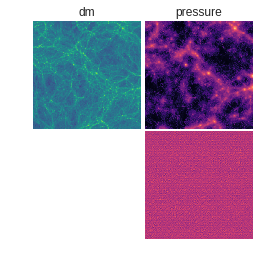

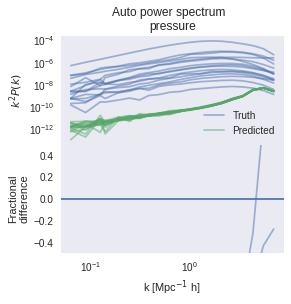

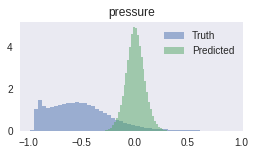

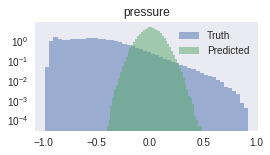

Epoch: [0/15], Batch: [200/2457], Loss: -3.862e+03
Processed batches: 201, processed samples: 201, batch size: 1, learning rate: 1.0e-04
ELBO                      : -3.862e+03     KL_term                   : -9.469e+01     log_likelihood_0          : -3.767e+03     
log_likelihood_fixed_var_0: -3.860e+03     log_likelihood_free_var_0 : -3.767e+03     
Epoch: [0/15], Batch: [401/2457], Loss: 5.486e+03
Processed batches: 402, processed samples: 402, batch size: 1, learning rate: 1.0e-04
ELBO                      : 5.486e+03     KL_term                   : -4.136e+01     log_likelihood_0          : 5.528e+03     
log_likelihood_fixed_var_0: -8.389e+02     log_likelihood_free_var_0 : 5.528e+03     
Epoch: [0/15], Batch: [602/2457], Loss: 2.117e+04
Processed batches: 603, processed samples: 603, batch size: 1, learning rate: 1.0e-04
ELBO                      : 2.117e+04     KL_term                   : -5.691e+01     log_likelihood_0          : 2.122e+04     
log_likelihood_fixed_var_0: -7.5

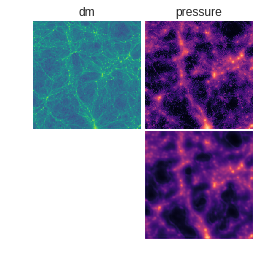

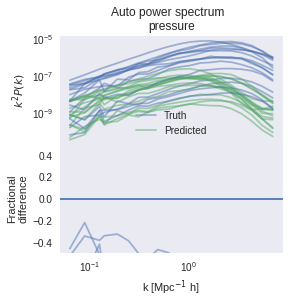

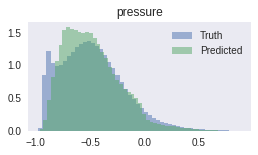

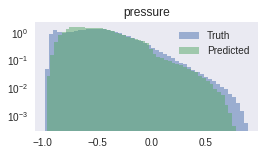

Epoch: [1/15], Batch: [155/2457], Loss: 1.064e+05
Processed batches: 2613, processed samples: 2613, batch size: 1, learning rate: 1.0e-04
ELBO                      : 1.064e+05     KL_term                   : -1.214e+03     log_likelihood_0          : 1.076e+05     
log_likelihood_fixed_var_0: -4.410e+02     log_likelihood_free_var_0 : 1.076e+05     
Epoch: [1/15], Batch: [356/2457], Loss: 1.045e+05
Processed batches: 2814, processed samples: 2814, batch size: 1, learning rate: 1.0e-04
ELBO                      : 1.045e+05     KL_term                   : -1.234e+03     log_likelihood_0          : 1.057e+05     
log_likelihood_fixed_var_0: -4.629e+02     log_likelihood_free_var_0 : 1.057e+05     
Epoch: [1/15], Batch: [557/2457], Loss: 1.067e+05
Processed batches: 3015, processed samples: 3015, batch size: 1, learning rate: 1.0e-04
ELBO                      : 1.067e+05     KL_term                   : -1.315e+03     log_likelihood_0          : 1.080e+05     
log_likelihood_fixed_var_0: -4

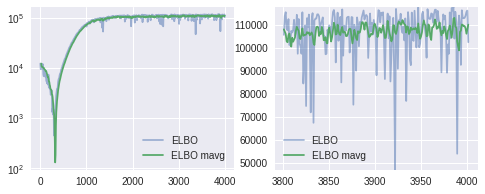

Epoch: [1/15], Batch: [1562/2457], Loss: 1.064e+05
Processed batches: 4020, processed samples: 4020, batch size: 1, learning rate: 1.0e-04
ELBO                      : 1.064e+05     KL_term                   : -1.484e+03     log_likelihood_0          : 1.079e+05     
log_likelihood_fixed_var_0: -4.321e+02     log_likelihood_free_var_0 : 1.079e+05     
Epoch: [1/15], Batch: [1763/2457], Loss: 1.061e+05
Processed batches: 4221, processed samples: 4221, batch size: 1, learning rate: 1.0e-04
ELBO                      : 1.061e+05     KL_term                   : -1.587e+03     log_likelihood_0          : 1.077e+05     
log_likelihood_fixed_var_0: -4.336e+02     log_likelihood_free_var_0 : 1.077e+05     
Epoch: [1/15], Batch: [1964/2457], Loss: 1.129e+05
Processed batches: 4422, processed samples: 4422, batch size: 1, learning rate: 1.0e-04
ELBO                      : 1.129e+05     KL_term                   : -1.614e+03     log_likelihood_0          : 1.145e+05     
log_likelihood_fixed_var_0:

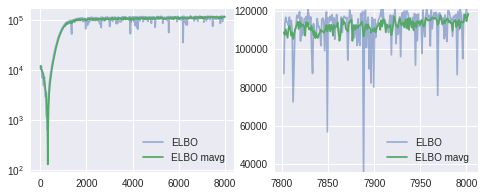

Epoch: [3/15], Batch: [668/2457], Loss: 1.184e+05
Processed batches: 8040, processed samples: 8040, batch size: 1, learning rate: 1.0e-04
ELBO                      : 1.184e+05     KL_term                   : -2.354e+03     log_likelihood_0          : 1.207e+05     
log_likelihood_fixed_var_0: -3.089e+02     log_likelihood_free_var_0 : 1.207e+05     
Epoch: [3/15], Batch: [869/2457], Loss: 1.124e+05
Processed batches: 8241, processed samples: 8241, batch size: 1, learning rate: 1.0e-04
ELBO                      : 1.124e+05     KL_term                   : -2.401e+03     log_likelihood_0          : 1.148e+05     
log_likelihood_fixed_var_0: -3.634e+02     log_likelihood_free_var_0 : 1.148e+05     
Epoch: [3/15], Batch: [1070/2457], Loss: 1.148e+05
Processed batches: 8442, processed samples: 8442, batch size: 1, learning rate: 1.0e-04
ELBO                      : 1.148e+05     KL_term                   : -2.417e+03     log_likelihood_0          : 1.172e+05     
log_likelihood_fixed_var_0: -

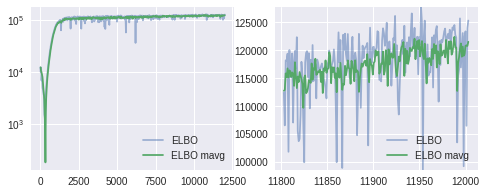

Epoch: [4/15], Batch: [2231/2457], Loss: 1.204e+05
Processed batches: 12060, processed samples: 12060, batch size: 1, learning rate: 1.0e-04
ELBO                      : 1.204e+05     KL_term                   : -3.031e+03     log_likelihood_0          : 1.235e+05     
log_likelihood_fixed_var_0: -2.874e+02     log_likelihood_free_var_0 : 1.235e+05     
Epoch: [4/15], Batch: [2432/2457], Loss: 1.204e+05
Processed batches: 12261, processed samples: 12261, batch size: 1, learning rate: 1.0e-04
ELBO                      : 1.204e+05     KL_term                   : -3.009e+03     log_likelihood_0          : 1.235e+05     
log_likelihood_fixed_var_0: -2.845e+02     log_likelihood_free_var_0 : 1.235e+05     
 ===== Validate ===== 


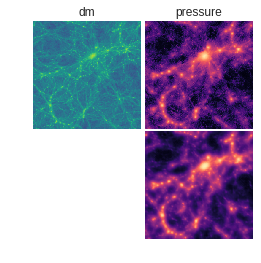

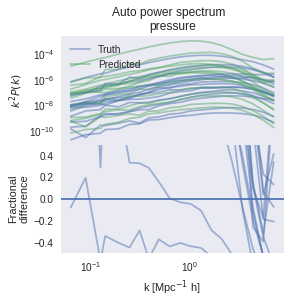

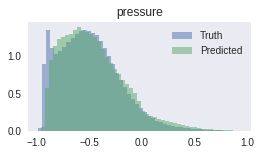

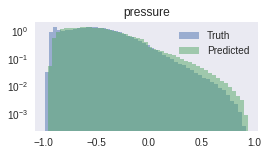

Epoch: [5/15], Batch: [88/1228], Loss: 1.236e+05
Processed batches: 12374, processed samples: 12463, batch size: 2, learning rate: 1.0e-04
ELBO                      : 1.236e+05     KL_term                   : -3.026e+03     log_likelihood_0          : 1.266e+05     
log_likelihood_fixed_var_0: -2.667e+02     log_likelihood_free_var_0 : 1.266e+05     
Epoch: [5/15], Batch: [189/1228], Loss: 1.249e+05
Processed batches: 12475, processed samples: 12665, batch size: 2, learning rate: 1.0e-04
ELBO                      : 1.249e+05     KL_term                   : -3.070e+03     log_likelihood_0          : 1.279e+05     
log_likelihood_fixed_var_0: -2.590e+02     log_likelihood_free_var_0 : 1.279e+05     
Epoch: [5/15], Batch: [290/1228], Loss: 1.239e+05
Processed batches: 12576, processed samples: 12867, batch size: 2, learning rate: 1.0e-04
ELBO                      : 1.239e+05     KL_term                   : -3.068e+03     log_likelihood_0          : 1.270e+05     
log_likelihood_fixed_var_

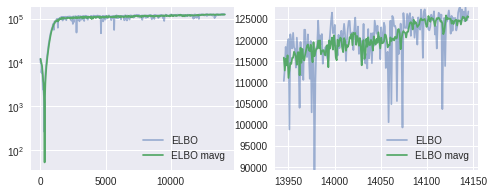

Epoch: [6/15], Batch: [677/1228], Loss: 1.245e+05
Processed batches: 14192, processed samples: 16098, batch size: 2, learning rate: 1.0e-04
ELBO                      : 1.245e+05     KL_term                   : -3.415e+03     log_likelihood_0          : 1.280e+05     
log_likelihood_fixed_var_0: -2.576e+02     log_likelihood_free_var_0 : 1.280e+05     
Epoch: [6/15], Batch: [778/1228], Loss: 1.247e+05
Processed batches: 14293, processed samples: 16300, batch size: 2, learning rate: 1.0e-04
ELBO                      : 1.247e+05     KL_term                   : -3.412e+03     log_likelihood_0          : 1.281e+05     
log_likelihood_fixed_var_0: -2.590e+02     log_likelihood_free_var_0 : 1.281e+05     
Epoch: [6/15], Batch: [879/1228], Loss: 1.236e+05
Processed batches: 14394, processed samples: 16502, batch size: 2, learning rate: 1.0e-04
ELBO                      : 1.236e+05     KL_term                   : -3.445e+03     log_likelihood_0          : 1.270e+05     
log_likelihood_fixed_var

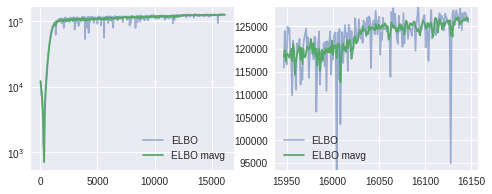

Epoch: [8/15], Batch: [239/1228], Loss: 1.259e+05
Processed batches: 16212, processed samples: 20136, batch size: 2, learning rate: 1.0e-04
ELBO                      : 1.259e+05     KL_term                   : -3.792e+03     log_likelihood_0          : 1.297e+05     
log_likelihood_fixed_var_0: -2.495e+02     log_likelihood_free_var_0 : 1.297e+05     
Epoch: [8/15], Batch: [340/1228], Loss: 1.270e+05
Processed batches: 16313, processed samples: 20338, batch size: 2, learning rate: 1.0e-04
ELBO                      : 1.270e+05     KL_term                   : -3.814e+03     log_likelihood_0          : 1.309e+05     
log_likelihood_fixed_var_0: -2.428e+02     log_likelihood_free_var_0 : 1.309e+05     
Epoch: [8/15], Batch: [441/1228], Loss: 1.271e+05
Processed batches: 16414, processed samples: 20540, batch size: 2, learning rate: 1.0e-04
ELBO                      : 1.271e+05     KL_term                   : -3.841e+03     log_likelihood_0          : 1.309e+05     
log_likelihood_fixed_var

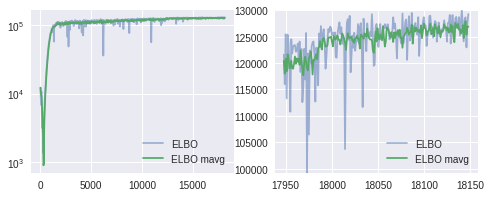

Epoch: [9/15], Batch: [1030/1228], Loss: 1.250e+05
Processed batches: 18232, processed samples: 24175, batch size: 2, learning rate: 1.0e-04
ELBO                      : 1.250e+05     KL_term                   : -4.110e+03     log_likelihood_0          : 1.291e+05     
log_likelihood_fixed_var_0: -2.525e+02     log_likelihood_free_var_0 : 1.291e+05     
Epoch: [9/15], Batch: [1131/1228], Loss: 1.272e+05
Processed batches: 18333, processed samples: 24377, batch size: 2, learning rate: 1.0e-04
ELBO                      : 1.272e+05     KL_term                   : -4.127e+03     log_likelihood_0          : 1.313e+05     
log_likelihood_fixed_var_0: -2.394e+02     log_likelihood_free_var_0 : 1.313e+05     
 ===== Validate ===== 


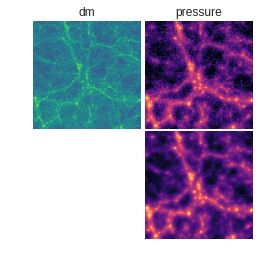

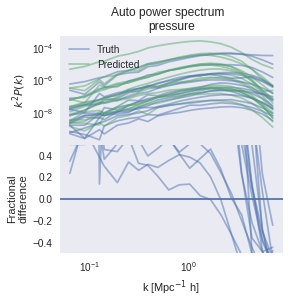

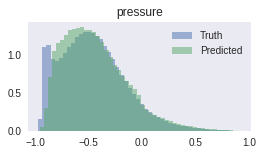

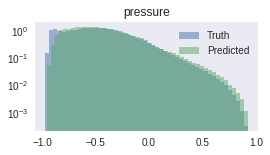

Epoch: [10/15], Batch: [1/614], Loss: 1.269e+05
Processed batches: 18432, processed samples: 24578, batch size: 4, learning rate: 1.0e-04
ELBO                      : 1.269e+05     KL_term                   : -4.150e+03     log_likelihood_0          : 1.311e+05     
log_likelihood_fixed_var_0: -2.399e+02     log_likelihood_free_var_0 : 1.311e+05     
Epoch: [10/15], Batch: [52/614], Loss: 1.284e+05
Processed batches: 18483, processed samples: 24782, batch size: 4, learning rate: 1.0e-04
ELBO                      : 1.284e+05     KL_term                   : -4.150e+03     log_likelihood_0          : 1.326e+05     
log_likelihood_fixed_var_0: -2.336e+02     log_likelihood_free_var_0 : 1.326e+05     
Epoch: [10/15], Batch: [103/614], Loss: 1.280e+05
Processed batches: 18534, processed samples: 24986, batch size: 4, learning rate: 1.0e-04
ELBO                      : 1.280e+05     KL_term                   : -4.158e+03     log_likelihood_0          : 1.322e+05     
log_likelihood_fixed_var_0:

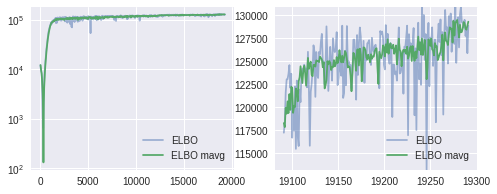

Epoch: [11/15], Batch: [253/614], Loss: 1.287e+05
Processed batches: 19299, processed samples: 28043, batch size: 4, learning rate: 1.0e-04
ELBO                      : 1.287e+05     KL_term                   : -4.281e+03     log_likelihood_0          : 1.330e+05     
log_likelihood_fixed_var_0: -2.329e+02     log_likelihood_free_var_0 : 1.330e+05     
Epoch: [11/15], Batch: [304/614], Loss: 1.294e+05
Processed batches: 19350, processed samples: 28247, batch size: 4, learning rate: 1.0e-04
ELBO                      : 1.294e+05     KL_term                   : -4.277e+03     log_likelihood_0          : 1.337e+05     
log_likelihood_fixed_var_0: -2.304e+02     log_likelihood_free_var_0 : 1.337e+05     
Epoch: [11/15], Batch: [355/614], Loss: 1.283e+05
Processed batches: 19401, processed samples: 28451, batch size: 4, learning rate: 1.0e-04
ELBO                      : 1.283e+05     KL_term                   : -4.285e+03     log_likelihood_0          : 1.326e+05     
log_likelihood_fixed_var

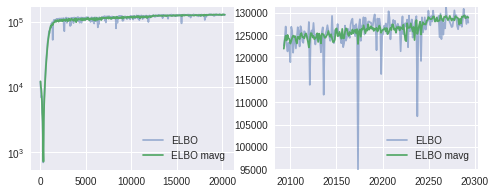

Epoch: [13/15], Batch: [43/614], Loss: 1.289e+05
Processed batches: 20319, processed samples: 32117, batch size: 4, learning rate: 1.0e-04
ELBO                      : 1.289e+05     KL_term                   : -4.453e+03     log_likelihood_0          : 1.333e+05     
log_likelihood_fixed_var_0: -2.297e+02     log_likelihood_free_var_0 : 1.333e+05     
Epoch: [13/15], Batch: [94/614], Loss: 1.293e+05
Processed batches: 20370, processed samples: 32321, batch size: 4, learning rate: 1.0e-04
ELBO                      : 1.293e+05     KL_term                   : -4.458e+03     log_likelihood_0          : 1.338e+05     
log_likelihood_fixed_var_0: -2.289e+02     log_likelihood_free_var_0 : 1.338e+05     
Epoch: [13/15], Batch: [145/614], Loss: 1.275e+05
Processed batches: 20421, processed samples: 32525, batch size: 4, learning rate: 1.0e-04
ELBO                      : 1.275e+05     KL_term                   : -4.464e+03     log_likelihood_0          : 1.319e+05     
log_likelihood_fixed_var_0

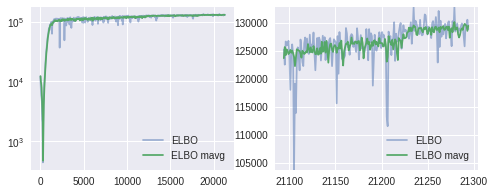

Epoch: [14/15], Batch: [448/614], Loss: 1.304e+05
Processed batches: 21339, processed samples: 36194, batch size: 4, learning rate: 1.0e-04
ELBO                      : 1.304e+05     KL_term                   : -4.588e+03     log_likelihood_0          : 1.350e+05     
log_likelihood_fixed_var_0: -2.226e+02     log_likelihood_free_var_0 : 1.350e+05     
Epoch: [14/15], Batch: [499/614], Loss: 1.296e+05
Processed batches: 21390, processed samples: 36398, batch size: 4, learning rate: 1.0e-04
ELBO                      : 1.296e+05     KL_term                   : -4.593e+03     log_likelihood_0          : 1.342e+05     
log_likelihood_fixed_var_0: -2.264e+02     log_likelihood_free_var_0 : 1.342e+05     
Epoch: [14/15], Batch: [550/614], Loss: 1.301e+05
Processed batches: 21441, processed samples: 36602, batch size: 4, learning rate: 1.0e-04
ELBO                      : 1.301e+05     KL_term                   : -4.612e+03     log_likelihood_0          : 1.347e+05     
log_likelihood_fixed_var

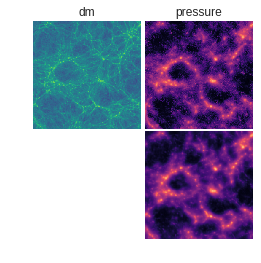

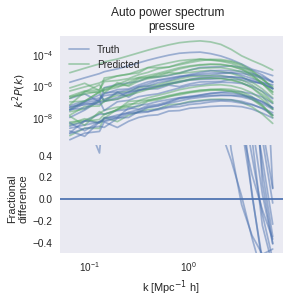

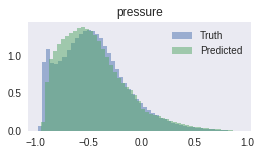

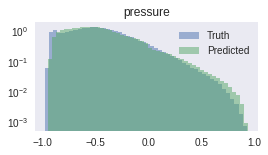

In [144]:
dtype = torch.float
device = torch.device("cuda")

n_x_feature = len(BAHAMAS_data.fields)-1

dim_x = (n_x_feature, *BAHAMAS_data.dim)
dim_y = (1, *BAHAMAS_data.dim)

dim_z = (1, 64, 64)
test_net =         {"type" :        "Type-1",
                    "dim_x" :       dim_x,
                    "dim_y" :       dim_y,
                    "dim_z" :       dim_z,
                    "n_x_features": n_x_feature,
                    "q_x_in" :        conv_block(n_x_feature, 8, kernel=5)
                                    + conv_down(in_channel=8, channels=[16], scales=[4,]),
                    "q_y_in" :        conv_block(1, 8, kernel=5)
                                    + conv_down(in_channel=8, channels=[16,], scales=[4,]),
                    "q_x_y_out" :     [("residual block", res_block(32)),
                                       ("residual block", res_block(32)),
                                      ]
                                    + conv_block(32, 2*dim_z[0], kernel=5)
                                    + [("unflatten", (2, *dim_z)),],
                    "p_y_in" :      None,
                    "p_z_in" :      conv_up(1, channels=[1,], scales=[4,], bias=False, batchnorm=True),
                    "p_y_z_in" :      conv_block(2, 16, kernel=5)
                                    + conv_down(in_channel=16, channels=[32, 64], scales=[2, 2])
                                    + [("residual block", res_block(64)),
                                       ("residual block", res_block(64)),
                                      ]
                                    + conv_up(64, channels=[32, 16], scales=[2,2], bias=False, batchnorm=True, activation="PReLU"),
                    "p_y_z_out" :   (# Mu 
                                      conv_block(16, n_x_feature, kernel=5, bias=False, batchnorm=False, activation="PReLU")
                                    + conv_block(n_x_feature, n_x_feature, kernel=3, bias=False, batchnorm=False, activation="tanh"),
                                     # Var
                                      conv_block(16, n_x_feature, kernel=5, bias=False, batchnorm=False, activation="PReLU")
                                    + conv_block(n_x_feature, n_x_feature, kernel=3, bias=False, batchnorm=False, activation=None)
                                    ),
                    "L" :           1,
                    }

n_epoch = 15
learning_rate = 1e-4

plot_reporting_frequency = 4000
stats_reporting_frequency = 200
mavg_window = stats_reporting_frequency


batch_size = 1

# torch.manual_seed(1234)
# torch.cuda.manual_seed(1234)

cvae = CVAE(test_net, device)

if device.type == "cuda":
    cvae.cuda()
cvae.check_gpu()


stats["test"] = train(cvae, BAHAMAS_data, n_epoch, learning_rate, batch_size=batch_size,
#           var_anneal_fn=lambda epoch: min(1.0, epoch**2*0.01),
#           adaptive_learning_rate={"step_size" : 2, "gamma" : 0.7},
                      adaptive_batch_size=lambda epoch: 2**(epoch//5),
                      validation_epochs=[0, 1, 5, 10], validation_batch_size=16,
                      reporting_frequency={"stats" : stats_reporting_frequency, "plots" : plot_reporting_frequency},
                      output_path="/tmp/output/test/")



In [150]:
dtype = torch.float
device = torch.device("cuda")

n_x_feature = len(BAHAMAS_data.fields)-1

dim_x = (n_x_feature, *BAHAMAS_data.dim)

dim_y = (1, *BAHAMAS_data.dim)


def create_q_out_architecture(type, in_channel, dim_z, dim_q_in=None):
    if type.lower() == "linear":
        architecture = [
                        ("linear",       {"in_features"   : in_channel*dim_q_in[0]*dim_q_in[1]*dim_q_in[2],
                                          "out_features"  : 2*dim_z[0]*dim_z[1]*dim_z[2],
                                          "bias"          : False}),
                        ("UnFlatten",     (2, *dim_z)),
                       ]
    elif type.lower() == "conv":            
        architecture = conv_block(in_channel=in_channel, out_channel=2*dim_z[0], batchnorm=False, activation="none")
        architecture += [("UnFlatten",     (2, *dim_z)),]
    else:
        raise NotImplementedError("Type {} not supported yet!".format(type))
        
    return architecture

def create_p_y_in_architecture(in_channel=1, kernel=9, channels=[16, 32, 64], scales=[1, 2, 2]):
    pre = conv_block(in_channel=1, out_channel=channels[0], scale=scales[0], kernel=kernel)
    architecture = pre + conv_down(in_channel=channels[0], channels=channels[1:], scales=scales[1:])
    return architecture
                     
def create_p_y_z_in_architecture(in_channel, res_channel, n_res_block, conv_up_channels, conv_up_scales, in_kernel=3):
    architecture = conv_block(in_channel=in_channel, out_channel=res_channel, kernel=in_kernel)
    
    for i in range(n_res_block):
        architecture += [("residual block", res_block(res_channel)),]
         
    architecture += conv_up(in_channel=res_channel, channels=conv_up_channels, scales=conv_up_scales, batchnorm=False, bias=True)
        
    return architecture
                
def create_p_out_architecture(type, in_channel, n_x_feature, kernel=[5, 5], predict_variance=False):
    pre = conv_block(in_channel=in_channel, out_channel=in_channel, kernel=kernel[0], batchnorm=False, bias=True)
    
    if type.lower() == "conv":
        if predict_variance:
            mu_architecture = pre + conv_block(in_channel=in_channel, out_channel=n_x_feature, kernel=kernel[1], bias=True, batchnorm=False, activation="none")
            mu_architecture += [("tanh",),]
            var_architecture = pre + conv_block(in_channel=in_channel, out_channel=n_x_feature, kernel=kernel[1], bias=True, batchnorm=False, activation="none")
            return mu_architecture, var_architecture
        else:
            mu_architecture = pre + conv_block(in_channel=in_channel, out_channel=n_x_feature, kernel=kernel[1], bias=True, batchnorm=False, activation="none")
            mu_architecture += [("tanh",),]
            return mu_architecture,      
    else:
        raise NotImplementedError("Type {} not supported yet!".format(type))
        
dim_z = (n_x_feature+1, 8, 8)
architecture =     {"type" :        "Type-1",
                    "dim_x" :       dim_x,
                    "dim_y" :       dim_y,
                    "dim_z" :       dim_z,
                    "n_x_features": n_x_feature,
                    "q_x_in" :      conv_down(in_channel=n_x_feature, channels=[8, 16, 32], scales=[2, 4, 4]),
                    "q_y_in" :      conv_down(in_channel=1, channels=[8, 16, 32], scales=[2, 4, 4]),
                    # In: N x 32+32 x 8 x 8
                    "q_x_y_out" :   create_q_out_architecture(type="conv", in_channel=64, dim_z=dim_z),
                    "p_y_in" :      create_p_y_in_architecture(in_channel=1, channels=[32, 64, 128], kernel=9, scales=[1, 2, 2]),
                    "p_z_in" :      conv_up(in_channel=dim_z[0], channels=[8, 32], scales=[2, 4]),
                    "p_y_z_in" :    create_p_y_z_in_architecture(in_channel=160, res_channel=128, n_res_block=8, conv_up_channels=[64, 32], conv_up_scales=[2, 2], in_kernel=3),
                    "p_y_z_out" :   create_p_out_architecture(type="conv", in_channel=32, n_x_feature=n_x_feature, kernel=[7,3], predict_variance=False),
                    "L" :           1,
                    }

dim_z = (1, 256, 256)
full_res_net =     {"type" :        "Type-1",
                    "dim_x" :       dim_x,
                    "dim_y" :       dim_y,
                    "dim_z" :       dim_z,
                    "n_x_features": n_x_feature,
                    "q_x_in" :        conv_block(n_x_feature, 16, kernel=9)
                                    + conv_down(in_channel=16, channels=[32, 64], scales=[2, 2]),
                    "q_y_in" :        conv_block(1, 16, kernel=9)
                                    + conv_down(in_channel=16, channels=[32, 64], scales=[2, 2]),
                    # In: N x 128 x 64 x 64
                    "q_x_y_out" :     [("residual block", res_block(128)),
#                                        ("residual block", res_block(128)),
                                      ]
                                    + conv_up(128, channels=[64, 32], scales=[2,2])
                                    + conv_block(32, 2*dim_z[0], kernel=9)
                                    + [("unflatten", (2, *dim_z)),],
                    "p_y_in" :      None,
                    "p_z_in" :      None,
                    "p_y_z_in" :      conv_block(2, 32, kernel=9)
                                    + conv_down(in_channel=32, channels=[64, 128], scales=[2, 2])
                                    + [("residual block", res_block(128)),
#                                        ("residual block", res_block(128)),
                                      ]
                                    + conv_up(128, channels=[64, 32], scales=[2,2], bias=True, batchnorm=False),
                    "p_y_z_out" :   ( conv_block(32, n_x_feature, kernel=9, bias=True, batchnorm=False, activation="none")
#                                     + conv_block(n_x_feature, n_x_feature, kernel=3, bias=True, batchnorm=False, activation="none")
                                    + [("tanh",),],
                                    ),
                    "L" :           1,
                    }


dim_z = (1, 64, 64)
test_net =         {"type" :        "Type-1",
                    "dim_x" :       dim_x,
                    "dim_y" :       dim_y,
                    "dim_z" :       dim_z,
                    "n_x_features": n_x_feature,
                    "q_x_in" :        conv_block(n_x_feature, 8, kernel=5)
                                    + conv_down(in_channel=8, channels=[16], scales=[4,]),
                    "q_y_in" :        conv_block(1, 8, kernel=5)
                                    + conv_down(in_channel=8, channels=[16,], scales=[4,]),
                    "q_x_y_out" :     [("residual block", res_block(32)),
                                       ("residual block", res_block(32)),
                                      ]
                                    + conv_block(32, 2*dim_z[0], kernel=5)
                                    + [("unflatten", (2, *dim_z)),],
                    "p_y_in" :      None,
                    "p_z_in" :      conv_up(1, channels=[1,], scales=[4,], bias=False, batchnorm=True),
                    "p_y_z_in" :      conv_block(2, 16, kernel=5)
                                    + conv_down(in_channel=16, channels=[32, 64], scales=[2, 2])
                                    + [("residual block", res_block(64)),
                                       ("residual block", res_block(64)),
                                      ]
                                    + conv_up(64, channels=[32, 16], scales=[2,2], bias=False, batchnorm=True, activation="PReLU"),
                    "p_y_z_out" :   (# Mu 
                                      conv_block(16, n_x_feature, kernel=5, bias=False, batchnorm=False, activation="PReLU")
                                    + conv_block(n_x_feature, n_x_feature, kernel=3, bias=False, batchnorm=False, activation="tanh"),
                                     # Var
                                      conv_block(16, n_x_feature, kernel=5, bias=False, batchnorm=False, activation="PReLU")
                                    + conv_block(n_x_feature, n_x_feature, kernel=3, bias=False, batchnorm=False, activation=None)
                                    ),
                    "L" :           1,
#                     "x_var_init_std": 1e-6,
                    }

# dim_z = (1, 256, 256)
# res_net2 =         {"type" :        "Type-1",
#                     "dim_x" :       dim_x,
#                     "dim_y" :       dim_y,
#                     "dim_z" :       dim_z,
#                     "n_x_features": n_x_feature,
#                     "q_x_in" :        conv_block(n_x_feature, 16, kernel=7)
#                                     + conv_down(in_channel=16, channels=[32, 32], scales=[2, 2]),
#                     "q_y_in" :        conv_block(1, 16, kernel=7)
#                                     + conv_down(in_channel=16, channels=[32, 32], scales=[2, 2]),
#                     "q_x_y_out" :     [("residual block", res_block(64)),
#                                        ("residual block", res_block(64)),
#                                       ]
#                                     + conv_block(64, 2*dim_z[0], kernel=5, activation="prelu")
#                                     + [("unflatten", (2, *dim_z)),],
#                     "p_y_in" :      None,
#                     "p_z_in" :      None,
#                     "p_y_z_in" :      conv_block(2, 32, kernel=7)
#                                     + conv_down(in_channel=32, channels=[32, 64], scales=[2, 2])
#                                     + [("residual block", res_block(64)),
#                                        ("residual block", res_block(64)),
#                                       ]
#                                     + conv_up(64, channels=[32, 32], scales=[2,2], bias=False, batchnorm=True, activation="PReLU"),
#                     "p_y_z_out" :   (# Mu 
#                                       conv_block(32, 16, kernel=7, bias=False, batchnorm=False, activation="PReLU")
#                                     + conv_block(16, n_x_feature, kernel=5, bias=False, batchnorm=False, activation="PReLU")
#                                     + conv_block(n_x_feature, n_x_feature, kernel=3, bias=False, batchnorm=False, activation="tanh"),
# #                                      # Var
# #                                       conv_block(16, n_x_feature, kernel=5, bias=False, batchnorm=False, relu=True)
# #                                     + conv_block(n_x_feature, n_x_feature, kernel=3, bias=False, batchnorm=False, relu=False)
#                                     ),
#                     "L" :           1,
#                     "x_var_init_std": 1e-6,
#                     }

cvae = CVAE(test_net, device)

print(cvae)
cvae.print_model_statistics()

if device.type == "cuda":
    print("Using CUDA!")
    cvae.cuda()
cvae.check_gpu()

batch_size = 1


n_epoch = 20
learning_rate = 5e-4

plot_reporting_frequency = 4000
stats_reporting_frequency = 200
mavg_window = stats_reporting_frequency

train(cvae, BAHAMAS_data, n_epoch, batch_size, learning_rate,
#           var_anneal_fn=lambda epoch: min(1.0, epoch**2*0.01),
#           adaptive_learning_rate={"step_size" : 2, "gamma" : 0.7},
      adaptive_batch_size=lambda epoch: 2**(epoch//4),
      reporting_frequency={"stats" : stats_reporting_frequency, "plots" : plot_reporting_frequency},
      output_path="/tmp/output/adaptive_M_var/")
      
      
# # shutil.rmtree("/tmp/output")
# import cProfile
# import io
# import pstats

# profiler = cProfile.Profile()
# profiler.enable()
# train(cvae, BAHAMAS_data, n_epoch, batch_size, learning_rate,
#       var_anneal_fn=lambda epoch: min(1.0, epoch**2*0.01),
#       adaptive_learning_rate={"step_size" : 2, "gamma" : 0.7},
#       reporting_frequency={"stats" : stats_reporting_frequency, "plots" : plot_reporting_frequency},
#       output_path="/tmp/output/")
# profiler.disable()
# s = io.StringIO()
# sortby = 'cumulative'
# ps = pstats.Stats(profiler, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())


CVAE with Type-1 architecture.
CVAE(
  (q_x_in): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(8, 16, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
  )
  (q_y_in): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(8, 16, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
  )
  (q_out): Sequential(
    (0): ResidualBlock(
      (res_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(

KeyboardInterrupt: ignored

## Test different configs

CVAE with Type-1 architecture.
Processed batches: 201, processed samples: 201, learning rate: 1.0e-04
Epoch: [0/25], Batch: [200/1536]
Total loss: 2207.1, KL term: 72.0, log-likelihood term: 2279.1
Fixed var loss: -183.2
Processed batches: 402, processed samples: 402, learning rate: 1.0e-04
Epoch: [0/25], Batch: [401/1536]
Total loss: 13914.5, KL term: 30.2, log-likelihood term: 13944.7
Fixed var loss: -231.5
Processed batches: 603, processed samples: 603, learning rate: 1.0e-04
Epoch: [0/25], Batch: [602/1536]
Total loss: 39440.2, KL term: 17.2, log-likelihood term: 39457.4
Fixed var loss: -225.4
Processed batches: 804, processed samples: 804, learning rate: 1.0e-04
Epoch: [0/25], Batch: [803/1536]
Total loss: 80851.2, KL term: 11.8, log-likelihood term: 80862.9
Fixed var loss: -190.4
Processed batches: 1005, processed samples: 1005, learning rate: 1.0e-04
Epoch: [0/25], Batch: [1004/1536]
Total loss: 128897.4, KL term: 11.1, log-likelihood term: 128908.5
Fixed var loss: -157.0
Proces

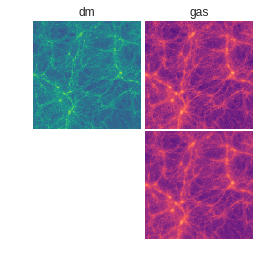

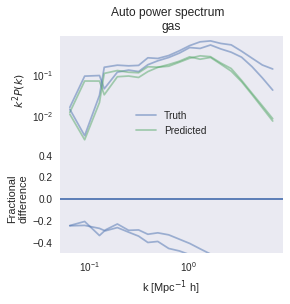

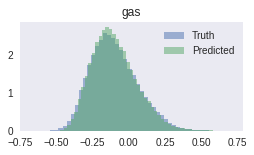

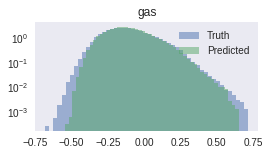

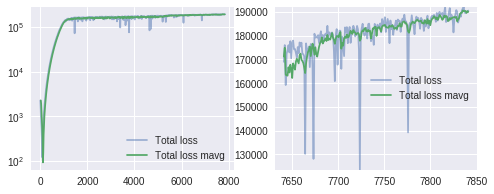

Processed batches: 7861, processed samples: 8042, learning rate: 1.0e-04
Epoch: [5/25], Batch: [180/768]
Total loss: 190259.1, KL term: 0.0, log-likelihood term: 190259.1
Fixed var loss: -45.8
Processed batches: 7962, processed samples: 8244, learning rate: 1.0e-04
Epoch: [5/25], Batch: [281/768]
Total loss: 190633.5, KL term: 0.0, log-likelihood term: 190633.5
Fixed var loss: -45.3
Processed batches: 8063, processed samples: 8446, learning rate: 1.0e-04
Epoch: [5/25], Batch: [382/768]
Total loss: 190592.9, KL term: 0.0, log-likelihood term: 190592.9
Fixed var loss: -45.1
Processed batches: 8164, processed samples: 8648, learning rate: 1.0e-04
Epoch: [5/25], Batch: [483/768]
Total loss: 191482.4, KL term: 0.0, log-likelihood term: 191482.4
Fixed var loss: -43.1
Processed batches: 8265, processed samples: 8850, learning rate: 1.0e-04
Epoch: [5/25], Batch: [584/768]
Total loss: 192628.9, KL term: 0.0, log-likelihood term: 192628.9
Fixed var loss: -41.8
Processed batches: 8366, processed 

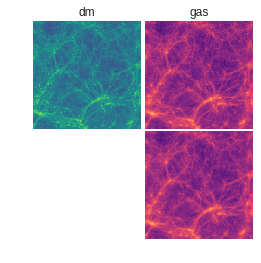

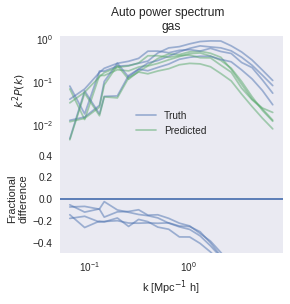

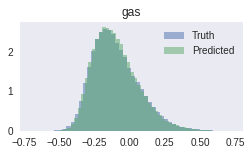

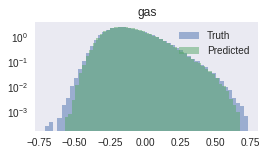

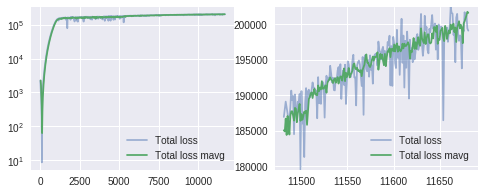

Processed batches: 11712, processed samples: 16128, learning rate: 1.0e-04
Epoch: [10/25], Batch: [191/384]
Total loss: 201817.1, KL term: 0.0, log-likelihood term: 201817.1
Fixed var loss: -34.8
Processed batches: 11763, processed samples: 16332, learning rate: 1.0e-04
Epoch: [10/25], Batch: [242/384]
Total loss: 201756.4, KL term: 0.0, log-likelihood term: 201756.4
Fixed var loss: -35.1
Processed batches: 11814, processed samples: 16536, learning rate: 1.0e-04
Epoch: [10/25], Batch: [293/384]
Total loss: 201979.3, KL term: 0.0, log-likelihood term: 201979.3
Fixed var loss: -34.7
Processed batches: 11865, processed samples: 16740, learning rate: 1.0e-04
Epoch: [10/25], Batch: [344/384]
Total loss: 201310.7, KL term: 0.0, log-likelihood term: 201310.7
Fixed var loss: -34.9
Processed batches: 11916, processed samples: 16944, learning rate: 1.0e-04
Epoch: [11/25], Batch: [11/384]
Total loss: 202120.1, KL term: 0.0, log-likelihood term: 202120.1
Fixed var loss: -34.4
Processed batches: 11

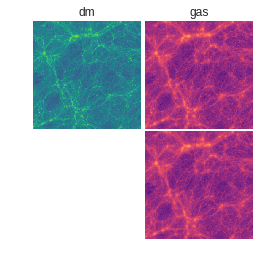

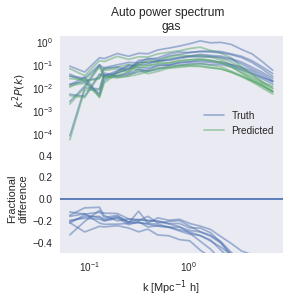

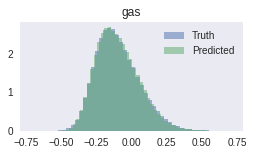

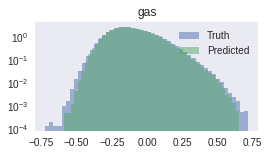

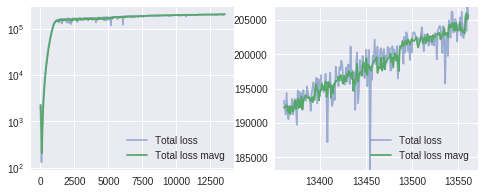

Processed batches: 13573, processed samples: 24104, learning rate: 1.0e-04
Epoch: [15/25], Batch: [132/192]
Total loss: 205911.9, KL term: 0.0, log-likelihood term: 205911.9
Fixed var loss: -32.4
Processed batches: 13599, processed samples: 24312, learning rate: 1.0e-04
Epoch: [15/25], Batch: [158/192]
Total loss: 205760.5, KL term: 0.0, log-likelihood term: 205760.5
Fixed var loss: -32.6
Processed batches: 13625, processed samples: 24520, learning rate: 1.0e-04
Epoch: [15/25], Batch: [184/192]
Total loss: 205436.3, KL term: 0.0, log-likelihood term: 205436.3
Fixed var loss: -32.4
Processed batches: 13651, processed samples: 24728, learning rate: 1.0e-04
Epoch: [16/25], Batch: [18/192]
Total loss: 206143.5, KL term: 0.0, log-likelihood term: 206143.5
Fixed var loss: -32.4
Processed batches: 13677, processed samples: 24936, learning rate: 1.0e-04
Epoch: [16/25], Batch: [44/192]
Total loss: 205982.7, KL term: 0.0, log-likelihood term: 205982.7
Fixed var loss: -32.4
Processed batches: 137

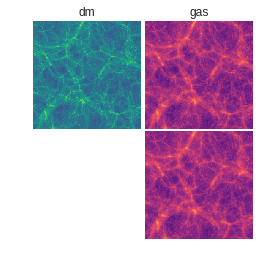

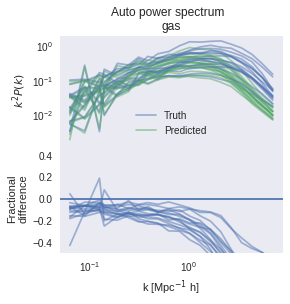

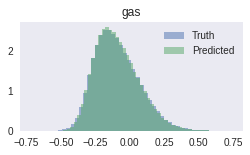

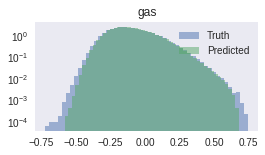

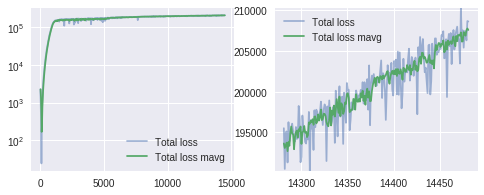

Processed batches: 14494, processed samples: 32224, learning rate: 1.0e-04
Epoch: [20/25], Batch: [93/96]
Total loss: 207753.7, KL term: 0.0, log-likelihood term: 207753.7
Fixed var loss: -31.5
Processed batches: 14507, processed samples: 32432, learning rate: 1.0e-04
Epoch: [21/25], Batch: [10/96]
Total loss: 207755.3, KL term: 0.0, log-likelihood term: 207755.3
Fixed var loss: -31.5
Processed batches: 14520, processed samples: 32640, learning rate: 1.0e-04
Epoch: [21/25], Batch: [23/96]
Total loss: 208005.5, KL term: 0.0, log-likelihood term: 208005.5
Fixed var loss: -31.5
Processed batches: 14533, processed samples: 32848, learning rate: 1.0e-04
Epoch: [21/25], Batch: [36/96]
Total loss: 207943.9, KL term: 0.0, log-likelihood term: 207943.9
Fixed var loss: -31.5
Processed batches: 14546, processed samples: 33056, learning rate: 1.0e-04
Epoch: [21/25], Batch: [49/96]
Total loss: 208239.9, KL term: 0.0, log-likelihood term: 208239.9
Fixed var loss: -31.4
Processed batches: 14559, proc

In [24]:
dtype = torch.float
device = torch.device("cuda")

n_x_feature = len(BAHAMAS_data.fields)-1

dim_x = (n_x_feature, *BAHAMAS_data.dim)
dim_y = (1, *BAHAMAS_data.dim)

dim_z = (1, 64, 64)
test_net =         {"type" :        "Type-1",
                    "dim_x" :       dim_x,
                    "dim_y" :       dim_y,
                    "dim_z" :       dim_z,
                    "n_x_features": n_x_feature,
                    "q_x_in" :        conv_block(n_x_feature, 8, kernel=5)
                                    + conv_down(in_channel=8, channels=[16], scales=[4,]),
                    "q_y_in" :        conv_block(1, 8, kernel=5)
                                    + conv_down(in_channel=8, channels=[16,], scales=[4,]),
                    "q_x_y_out" :     [("residual block", res_block(32)),
                                       ("residual block", res_block(32)),
                                      ]
                                    + conv_block(32, 2*dim_z[0], kernel=5)
                                    + [("unflatten", (2, *dim_z)),],
                    "p_y_in" :      None,
                    "p_z_in" :      conv_up(1, channels=[1,], scales=[4,], bias=False, batchnorm=True),
                    "p_y_z_in" :      conv_block(2, 16, kernel=5)
                                    + conv_down(in_channel=16, channels=[32, 64], scales=[2, 2])
                                    + [("residual block", res_block(64)),
                                       ("residual block", res_block(64)),
                                      ]
                                    + conv_up(64, channels=[32, 16], scales=[2,2], bias=False, batchnorm=True, activation="PReLU"),
                    "p_y_z_out" :   (# Mu 
                                      conv_block(16, n_x_feature, kernel=5, bias=False, batchnorm=False, activation="PReLU")
                                    + conv_block(n_x_feature, n_x_feature, kernel=3, bias=False, batchnorm=False, activation="tanh"),
                                     # Var
                                      conv_block(16, n_x_feature, kernel=5, bias=False, batchnorm=False, activation="PReLU")
                                    + conv_block(n_x_feature, n_x_feature, kernel=3, bias=False, batchnorm=False, activation=None)
                                    ),
                    "L" :           1,
                    }

n_epoch = 25
learning_rate = 1e-4

plot_reporting_frequency = 8000
stats_reporting_frequency = 200
mavg_window = stats_reporting_frequency

# stats = collections.OrderedDict()
    
# for i, (L, M) in enumerate([(1, 1), (1, 4), (4, 1)]):
#     print("Running config L: {}, M: {}".format(L, M))
    
#     batch_size = M
#     test_net["L"] = L
    
#     torch.manual_seed(1234)
#     torch.cuda.manual_seed(1234)
    
#     cvae = CVAE(test_net, device)

#     if device.type == "cuda":
#         cvae.cuda()
#     cvae.check_gpu()

    
#     stats[(L, M)] = train(cvae, BAHAMAS_data, n_epoch, batch_size, learning_rate*M,
# #           var_anneal_fn=lambda epoch: min(1.0, epoch**2*0.01),
# #           adaptive_learning_rate={"step_size" : 2, "gamma" : 0.7},
#           reporting_frequency={"stats" : stats_reporting_frequency, "plots" : plot_reporting_frequency},
#           output_path="/tmp/output/L{}M{}_epoch10_var/".format(L, M))

batch_size = 1
test_net["L"] = 1

torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

cvae = CVAE(test_net, device)

if device.type == "cuda":
    cvae.cuda()
cvae.check_gpu()


stats[(1,"1-16, 1e-4")] = train(cvae, BAHAMAS_data, n_epoch, batch_size, learning_rate,
#           var_anneal_fn=lambda epoch: min(1.0, epoch**2*0.01),
#           adaptive_learning_rate={"step_size" : 2, "gamma" : 0.7},
      adaptive_batch_size=lambda epoch: 2**(epoch//5),
      reporting_frequency={"stats" : stats_reporting_frequency, "plots" : plot_reporting_frequency},
      output_path="/tmp/output/L{}M{}_epoch25_adpt_bs/".format(1, 1))

# batch_size = 8
# test_net["L"] = 1

# torch.manual_seed(1234)
# torch.cuda.manual_seed(1234)

# cvae = CVAE(test_net, device)

# if device.type == "cuda":
#     cvae.cuda()
# cvae.check_gpu()


# stats[(1,"1-16")] = train(cvae, BAHAMAS_data, 50, batch_size, learning_rate*8,
# #           var_anneal_fn=lambda epoch: min(1.0, epoch**2*0.01),
# #           adaptive_learning_rate={"step_size" : 2, "gamma" : 0.7},
# #       adaptive_batch_size=lambda epoch: 2**(epoch//2),
#       reporting_frequency={"stats" : stats_reporting_frequency, "plots" : plot_reporting_frequency},
#       output_path="/tmp/output/L{}M{}_epoch50_adpt_lr/".format(L, M))

(20, 50)

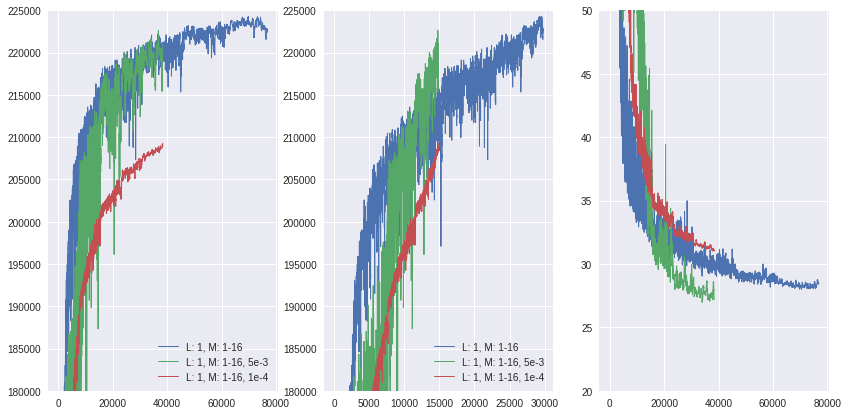

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7))

for i, ((L, M), s) in enumerate(stats.items()):
    ax[0].plot(s.n_processed_samples, np.abs(s.loss_terms["total_loss"]["mavg"]), lw=1, alpha=1, label="L: {}, M: {}".format(L, M))
    ax[1].plot(np.arange(s.n_batches), np.abs(s.loss_terms["total_loss"]["mavg"]), lw=1, alpha=1, label="L: {}, M: {}".format(L, M))
    ax[2].plot(s.n_processed_samples, np.abs(s.loss_terms["fixed_var"]["mavg"]), lw=1, alpha=1, label="L: {}, M: {}".format(L, M))
    
ax[0].legend()
ax[1].legend()
# ax[0].set_yscale("log")
# ax[1].set_yscale("log")
ax[0].set_ylim(180000, 225000)
ax[1].set_ylim(180000, 225000)
ax[2].set_ylim(20, 50)

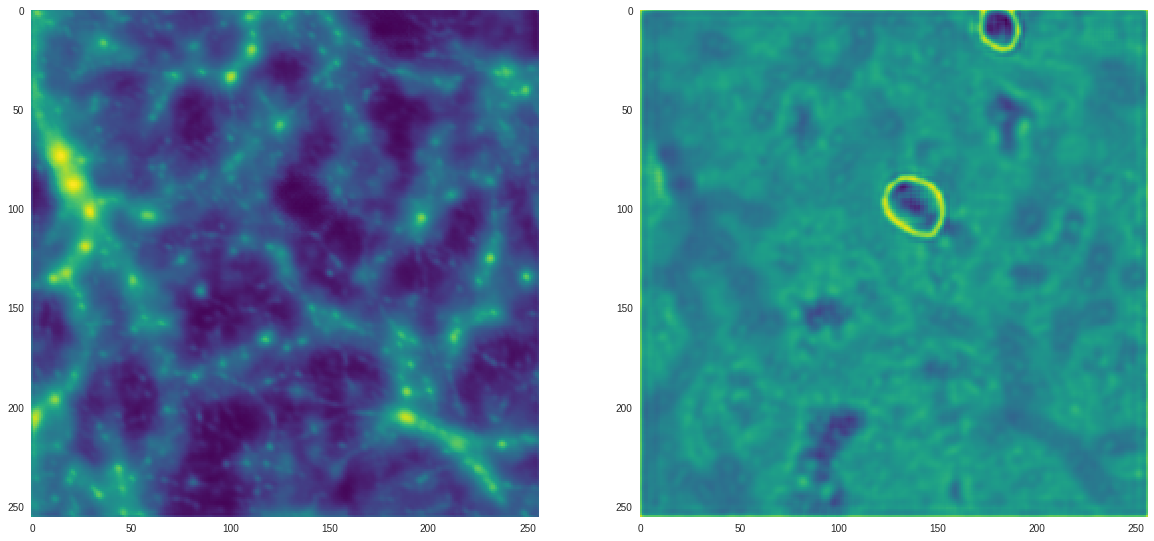

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

with torch.no_grad():
    ax[0].imshow(cvae.x_mu[0,0].cpu().numpy(), cmap="viridis")
    ax[0].grid("off")
    im = ax[1].imshow(np.log(cvae.x_var[0,0].cpu().numpy()), cmap="viridis")
    ax[1].grid("off")
#     plt.colorbar(im, ax=ax[1])
    
#     print(sum((cvae.x_mu[0,0] - x[0,0])**2))

In [58]:

with torch.no_grad():
    z = torch.randn(size=(batch_size, *dim_z), device=device)
    x_pred = cvae.P(z, y)[0]
#     %time fig, ax = plot_samples(x.cpu().numpy(), x_pred.cpu().numpy(), y.cpu().numpy(), \
#                            n_sample=2, tile_size=3, labels=["dm", "gas", "pressure", "stars"])
    
    %time fig2, ax2 = plot_power_spectra(x[:,0].cpu().numpy(), x_pred.cpu().numpy(), y.cpu().numpy(), \
                                 n_sample=None, labels=["gas", "pressure", "stars"], transforms=inv_field_transforms)
    %time fig2b, ax2b = plot_power_spectra(x[:,0].cpu().numpy(), x_pred.cpu().numpy(), y.cpu().numpy(), \
                                 n_sample=None, mode="cross", labels=["gas", "pressure", "stars"], transforms=inv_field_transforms)
    
    %time fig3, ax3 = plot_loss(stats)
    
    %time fig4, ax4 = plot_histogram(x[:,0].cpu().numpy(), x_pred.cpu().numpy(), labels=["gas", "pressure", "stars"])
    %time fig5, ax5 = plot_histogram(x[:,0].cpu().numpy(), x_pred.cpu().numpy(), labels=["gas", "pressure", "stars"], logscale=True)
#     grid = make_grid(x.cpu().numpy(), x_pred.detach().cpu().numpy(), y.detach().cpu().numpy(), n_sample=4)
    
#     fig, plots = plt.subplots(1, 1, figsize=(15, 9))

#     cmap = plt.get_cmap("viridis")
#     plots.imshow(grid, cmap=cmap)
#     plots.grid("off")
#     plots.set_xticks([])
#     plots.set_yticks([])
    
#     print(grid[np.isfinite(grid)].min(), grid[np.isfinite(grid)].max())

IndexError: ignored

ValueError: ignored

In [74]:
np.loadtxt("/tmp/output/stats.txt").shape

(29, 4)

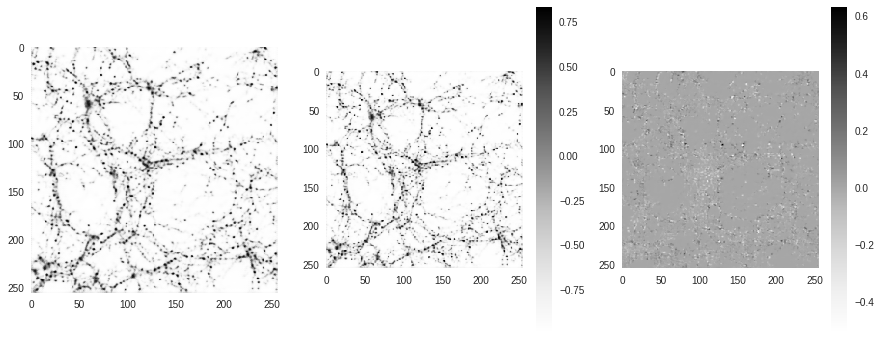

In [51]:
with torch.no_grad():
    z = torch.randn(size=(2, *dim_z), device=device)
    x_pred = cvae.P(z, y[:1], L=2)[0]
    
    i=2
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    ax[0].imshow(x_pred[0,i].squeeze())
    ax[0].grid("off")
    
    im = ax[1].imshow(x_pred[1,i].squeeze())
    ax[1].grid("off")
    plt.colorbar(im, ax=ax[1])
    
    im = ax[2].imshow(x_pred[0,i] - x_pred[1,i])
    ax[2].grid("off")
    plt.colorbar(im, ax=ax[2])



In [152]:
with torch.autograd.profiler.profile(use_cuda=True) as prof:
    cvae(x, y)
#     with torch.autograd.profiler.emit_nvtx():
#         cvae(x, y)
        
print(prof)

-------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------
Name                                    CPU time        CUDA time            Calls        CPU total       CUDA total
-------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------
conv2d                                1575.098us       2178.912us                1       1575.098us       2178.912us
convolution                           1475.638us       2137.408us                1       1475.638us       2137.408us
_convolution                          1413.234us       2085.184us                1       1413.234us       2085.184us
tensor                                  59.255us         54.336us                1         59.255us         54.336us
cudnn_convolution                     1089.209us       1802.624us                1       1089.209us       1802.624us
batch_norm                             719.590us       1225.120u

In [154]:
print(prof.table(sort_by="cuda_time_total"))

-------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------
Name                                    CPU time        CUDA time            Calls        CPU total       CUDA total
-------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------
tensor                                  23.652us          3.105us                1         23.652us          3.105us
tensor                                  23.699us          3.136us                1         23.699us          3.136us
tensor                                  21.860us          3.174us                1         21.860us          3.174us
tensor                                  26.640us          3.296us                1         26.640us          3.296us
tensor                                  33.082us          3.521us                1         33.082us          3.521us
tensor                                  22.266us          3.551u

In [32]:
with torch.no_grad():
    print(cvae.z_mu.cpu().numpy())
    print(np.exp(cvae.z_log_var.cpu().numpy()))

[[-0.03297838 -0.14184515 -0.01019404 ...  0.00192155  0.11732219
  -0.11228064]
 [-0.03127839  0.04475278 -0.03670011 ... -0.04727976  0.08883402
   0.02195656]
 [ 0.00175588 -0.07971327 -0.06093049 ...  0.01060458  0.08611741
  -0.09130932]
 ...
 [-0.01641202  0.02556952 -0.00771742 ...  0.00896102 -0.02018053
  -0.09046821]
 [ 0.03393316 -0.0139638  -0.02462362 ... -0.04150709  0.07651845
  -0.02241029]
 [-0.04959152 -0.0808424  -0.00129661 ...  0.05732725 -0.04724078
  -0.0376872 ]]
[[0.96712184 0.8645437  0.8824863  ... 0.9313757  0.92063427 0.93147016]
 [0.8446471  0.8542589  0.9126102  ... 0.8421411  0.7997194  0.9337923 ]
 [0.9041149  0.903374   0.84654003 ... 0.90615237 0.9336399  0.9313987 ]
 ...
 [0.8431784  0.8855606  0.81123495 ... 0.9354016  0.83376503 0.89197725]
 [0.87174904 0.95417345 0.9292313  ... 0.86590606 0.8853815  0.85981035]
 [0.8528806  0.9132164  0.83991784 ... 0.8299971  0.8042598  0.9505895 ]]


In [10]:
device

device(type='cuda')

In [28]:
(np.log10(2*pi/100*256/2)-np.log10(2*pi/100))/np.log10(2)+1

8.0

In [21]:
np.log10(np.logspace(0, 2, 10, endpoint=True))

array([0.        , 0.22222222, 0.44444444, 0.66666667, 0.88888889,
       1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ])

In [23]:
(np.log10(100)-np.log10(1))/9

0.2222222222222222

In [32]:
np.logspace(np.log10(2*pi/100), np.log10(2*pi/100*256/2), 16, endpoint=True)

array([0.06283185, 0.08682815, 0.11998893, 0.16581425, 0.22914085,
       0.3166527 , 0.43758644, 0.60470634, 0.83565148, 1.15479754,
       1.59582959, 2.20529747, 3.04752898, 4.21141955, 5.81981492,
       8.04247719])

In [74]:
torch.tensor([[1,2],[3,4]]).size() == (2,2)



True

In [1]:
sum(p.numel() for p in cvae.parameters() if p.requires_grad)

NameError: ignored

In [0]:
cumulative